***
# Model Deployment : Classifying Brain Tumors from Magnetic Resonance Images by Leveraging Convolutional Neural Network-Based Multilevel Feature Extraction and Hierarchical Representation 

***
### [**John Pauline Pineda**](https://github.com/JohnPaulinePineda) <br> <br> *November 30, 2024*
***

* [**1. Table of Contents**](#TOC)
    * [1.1 Data Background](#1.1)
    * [1.2 Data Description](#1.2)
    * [1.3 Data Quality Assessment](#1.3)
    * [1.4 Data Preprocessing](#1.4)
    * [1.5 Data Exploration](#1.5)
        * [1.5.1 Exploratory Data Analysis](#1.5.1)
        * [1.5.2 Hypothesis Testing](#1.5.2)
    * [1.6 Predictive Model Development](#1.6)
        * [1.6.1 Pre-Modelling Data Preparation](#1.6.1)
        * [1.6.2 Data Splitting](#1.6.2)
        * [1.6.3 Convolutional Neural Network Sequential Layer Development](#1.6.3)
            * [1.6.3.1 CNN With No Regularization](#1.6.3.1)
            * [1.6.3.2 CNN With Dropout Regularization](#1.6.3.2)
            * [1.6.3.3 CNN With Batch Normalization Regularization](#1.6.3.3)
            * [1.6.3.4 CNN With Dropout and Batch Normalization Regularization](#1.6.3.4)
        * [1.6.4 CNN With No Regularization Model Fitting | Hyperparameter Tuning | Validation](#1.6.4)
        * [1.6.5 CNN With Dropout Regularization Model Fitting | Hyperparameter Tuning | Validation](#1.6.5)
        * [1.6.6 CNN With Batch Normalization Regularization Model Fitting | Hyperparameter Tuning | Validation](#1.6.6)
        * [1.6.7 CNN With Dropout and Batch Normalization Regularization Model Fitting | Hyperparameter Tuning | Validation](#1.6.7)
        * [1.6.8 Model Selection](#1.6.8)
        * [1.6.9 Model Testing](#1.6.9)
        * [1.6.10 Model Inference](#1.6.10)
    * [1.7 Predictive Model Deployment Using Streamlit and Streamlit Community Cloud](#1.7)
        * [1.7.1 Model Application Programming Interface Code Development](#1.7.1)
        * [1.7.2 User Interface Application Code Development](#1.7.2)
        * [1.7.3 Web Application](#1.7.3)
* [**2. Summary**](#Summary)   
* [**3. References**](#References)

***

# 1. Table of Contents <a class="anchor" id="TOC"></a>

## 1.1 Data Background <a class="anchor" id="1.1"></a>

## 1.2 Data Description <a class="anchor" id="1.2"></a>

In [1]:
##################################
# Loading Python Libraries
##################################

##################################
# Data Loading, Data Preprocessing
# and Exploratory Data Analysis
##################################
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
%matplotlib inline

import tensorflow as tf
import keras

from PIL import Image
from glob import glob
import cv2
import os
import random
import math

##################################
# Model Development
##################################
from keras import backend as K
from keras import regularizers
from keras.models import Sequential, Model,load_model
from keras.layers import Input, Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, MaxPool2D, AveragePooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from math import ceil

##################################
# Model Evaluation
##################################
from keras.metrics import PrecisionAtRecall, Recall 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


In [2]:
##################################
# Setting random seed options
# for the analysis
##################################
def set_seed(seed=123):
    np.random.seed(seed) 
    tf.random.set_seed(seed) 
    keras.utils.set_random_seed(seed)
    random.seed(seed)
    tf.config.experimental.enable_op_determinism()
    os.environ['TF_DETERMINISTIC_OPS'] = "1"
    os.environ['TF_CUDNN_DETERMINISM'] = "1"
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()


In [3]:
##################################
# Filtering out unncessary warnings
##################################
import warnings
warnings.filterwarnings('ignore')


In [4]:
##################################
# Defining file paths
##################################
DATASETS_ORIGINAL_PATH = r"datasets\Brain_Tumor_MRI_Dataset"
DATASETS_FINAL_TRAIN_PATH = r"datasets\Brain_Tumor_MRI_Dataset\Training"
DATASETS_FINAL_TEST_PATH = r"datasets\Brain_Tumor_MRI_Dataset\Testing"
MODELS_PATH = r"models"
PARAMETERS_PATH = r"parameters"
PIPELINES_PATH = r"pipelines"


In [5]:
##################################
# Defining the image category levels
##################################
diagnosis_code_dictionary = {'Tr-no': 0,
                             'Tr-noTr': 0,
                             'Tr-gl': 1,
                             'Tr-glTr': 1,
                             'Tr-me': 2,
                             'Tr-meTr': 2,
                             'Tr-pi': 3,
                             'Tr-piTr': 3}

##################################
# Defining the image category descriptions
##################################
diagnosis_description_dictionary = {'Tr-no': 'No Tumor',
                                    'Tr-noTr': 'No Tumor',
                                    'Tr-gl': 'Glioma',
                                    'Tr-glTr': 'Glioma',
                                    'Tr-me': 'Meningioma',
                                    'Tr-meTr': 'Meningioma',
                                    'Tr-pi': 'Pituitary',
                                    'Tr-piTr': 'Pituitary'}

##################################
# Consolidating the image path
##################################
imageid_path_dictionary = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join("..", DATASETS_FINAL_TRAIN_PATH, '*','*.jpg'))}


In [6]:
##################################
# Taking a snapshot of the dictionary
##################################
dict(list(imageid_path_dictionary.items())[0:5]) 


{'Tr-glTr_0000': '..\\datasets\\Brain_Tumor_MRI_Dataset\\Training\\glioma\\Tr-glTr_0000.jpg',
 'Tr-glTr_0001': '..\\datasets\\Brain_Tumor_MRI_Dataset\\Training\\glioma\\Tr-glTr_0001.jpg',
 'Tr-glTr_0002': '..\\datasets\\Brain_Tumor_MRI_Dataset\\Training\\glioma\\Tr-glTr_0002.jpg',
 'Tr-glTr_0003': '..\\datasets\\Brain_Tumor_MRI_Dataset\\Training\\glioma\\Tr-glTr_0003.jpg',
 'Tr-glTr_0004': '..\\datasets\\Brain_Tumor_MRI_Dataset\\Training\\glioma\\Tr-glTr_0004.jpg'}

In [7]:
##################################
# Consolidating the information
# from the dataset
# into a dataframe
##################################
mri_images = pd.DataFrame.from_dict(imageid_path_dictionary, orient = 'index').reset_index()
mri_images.columns = ['Image_ID','Path']
classes = mri_images.Image_ID.str.split('_').str[0]
mri_images['Diagnosis'] = classes
mri_images['Target'] = mri_images['Diagnosis'].map(diagnosis_code_dictionary.get) 
mri_images['Class'] = mri_images['Diagnosis'].map(diagnosis_description_dictionary.get) 


In [8]:
##################################
# Performing a general exploration of the dataset
##################################
print('Dataset Dimensions: ')
display(mri_images.shape)


Dataset Dimensions: 


(5712, 5)

In [9]:
##################################
# Listing the column names and data types
##################################
print('Column Names and Data Types:')
display(mri_images.dtypes)


Column Names and Data Types:


Image_ID     object
Path         object
Diagnosis    object
Target        int64
Class        object
dtype: object

In [10]:
##################################
# Taking a snapshot of the dataset
##################################
mri_images.head()


Image_ID                                               Path Diagnosis  \
0  Tr-glTr_0000  ..\datasets\Brain_Tumor_MRI_Dataset\Training\g...   Tr-glTr   
1  Tr-glTr_0001  ..\datasets\Brain_Tumor_MRI_Dataset\Training\g...   Tr-glTr   
2  Tr-glTr_0002  ..\datasets\Brain_Tumor_MRI_Dataset\Training\g...   Tr-glTr   
3  Tr-glTr_0003  ..\datasets\Brain_Tumor_MRI_Dataset\Training\g...   Tr-glTr   
4  Tr-glTr_0004  ..\datasets\Brain_Tumor_MRI_Dataset\Training\g...   Tr-glTr   

   Target   Class  
0       1  Glioma  
1       1  Glioma  
2       1  Glioma  
3       1  Glioma  
4       1  Glioma

In [11]:
##################################
# Performing a general exploration of the numeric variables
##################################
print('Numeric Variable Summary:')
display(mri_images.describe(include='number').transpose())


Numeric Variable Summary:


count      mean       std  min  25%  50%  75%  max
Target  5712.0  1.465336  1.147892  0.0  0.0  1.0  3.0  3.0

In [12]:
##################################
# Performing a general exploration of the object variable
##################################
print('Object Variable Summary:')
display(mri_images.describe(include='object').transpose())


Object Variable Summary:


count unique                                                top  \
Image_ID   5712   5712                                         Tr-pi_1440   
Path       5712   5712  ..\datasets\Brain_Tumor_MRI_Dataset\Training\p...   
Diagnosis  5712      8                                              Tr-no   
Class      5712      4                                           No Tumor   

           freq  
Image_ID      1  
Path          1  
Diagnosis  1585  
Class      1595

In [13]:
##################################
# Performing a general exploration of the target variable
##################################
mri_images.Class.value_counts()


Class
No Tumor      1595
Pituitary     1457
Meningioma    1339
Glioma        1321
Name: count, dtype: int64

In [14]:
##################################
# Performing a general exploration of the target variable
##################################
mri_images.Class.value_counts(normalize=True)


Class
No Tumor      0.279237
Pituitary     0.255077
Meningioma    0.234419
Glioma        0.231268
Name: proportion, dtype: float64

## 1.3 Data Quality Assessment <a class="anchor" id="1.3"></a>

In [15]:
##################################
# Counting the number of duplicated images
##################################
mri_images.duplicated().sum()


np.int64(0)

In [16]:
##################################
# Gathering the number of null images
##################################
mri_images.isnull().sum()


Image_ID     0
Path         0
Diagnosis    0
Target       0
Class        0
dtype: int64

## 1.4 Data Preprocessing <a class="anchor" id="1.4"></a>

In [17]:
##################################
# Including the pixel information
# of the actual images
# in array format
# into a dataframe
##################################
mri_images['Image'] = mri_images['Path'].map(lambda x: np.asarray(Image.open(x).resize((200,200))))


In [18]:
##################################
# Listing the column names and data types
##################################
print('Column Names and Data Types:')
display(mri_images.dtypes)


Column Names and Data Types:


Image_ID     object
Path         object
Diagnosis    object
Target        int64
Class        object
Image        object
dtype: object

In [19]:
##################################
# Taking a snapshot of the dataset
##################################
mri_images.head()


Image_ID                                               Path Diagnosis  \
0  Tr-glTr_0000  ..\datasets\Brain_Tumor_MRI_Dataset\Training\g...   Tr-glTr   
1  Tr-glTr_0001  ..\datasets\Brain_Tumor_MRI_Dataset\Training\g...   Tr-glTr   
2  Tr-glTr_0002  ..\datasets\Brain_Tumor_MRI_Dataset\Training\g...   Tr-glTr   
3  Tr-glTr_0003  ..\datasets\Brain_Tumor_MRI_Dataset\Training\g...   Tr-glTr   
4  Tr-glTr_0004  ..\datasets\Brain_Tumor_MRI_Dataset\Training\g...   Tr-glTr   

   Target   Class                                              Image  
0       1  Glioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
1       1  Glioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
2       1  Glioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
3       1  Glioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
4       1  Glioma  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...

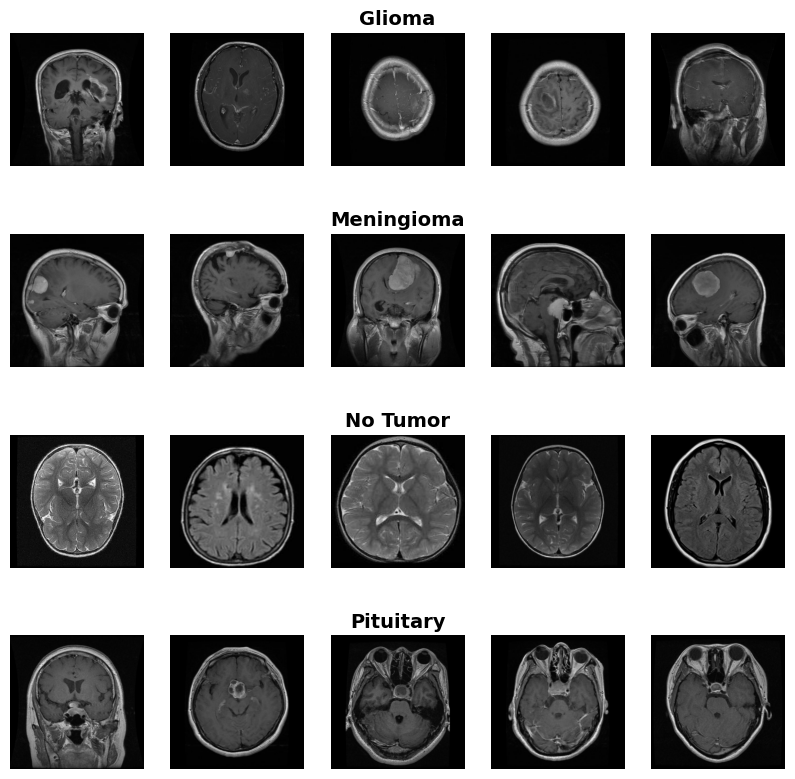

In [20]:
##################################
# Taking a snapshot of the dataset
##################################
n_samples = 5
fig, m_axs = plt.subplots(4, n_samples, figsize = (2*n_samples, 10))
for n_axs, (type_name, type_rows) in zip(m_axs, mri_images.sort_values(['Class']).groupby('Class')):
    n_axs[2].set_title(type_name, fontsize = 14, weight = 'bold')
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=123).iterrows()):       
        picture = c_row['Path']
        image = cv2.imread(picture)
        resized_image = cv2.resize(image, (500,500))
        c_ax.imshow(resized_image)
        c_ax.axis('off')
        

In [21]:
##################################
# Sampling a single image
##################################
samples, features = mri_images.shape
plt.figure()
pic_id = random.randrange(0, samples)
picture = mri_images['Path'][pic_id]
image = cv2.imread(picture) 


<Figure size 640x480 with 0 Axes>

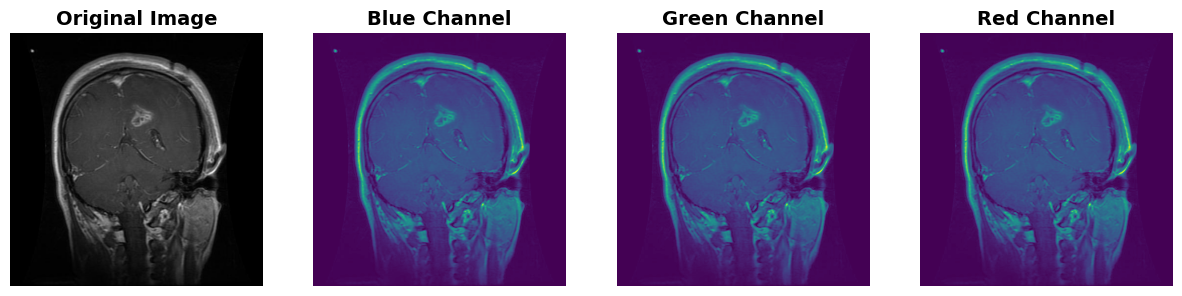

In [22]:
##################################
# Plotting using subplots
##################################
plt.figure(figsize=(15, 5))

##################################
# Formulating the original image
##################################
plt.subplot(1, 4, 1)
plt.imshow(image)
plt.title('Original Image', fontsize = 14, weight = 'bold')
plt.axis('off')

##################################
# Formulating the blue channel
##################################
plt.subplot(1, 4, 2)
plt.imshow(image[ : , : , 0])
plt.title('Blue Channel', fontsize = 14, weight = 'bold')
plt.axis('off')

##################################
# Formulating the green channel
##################################
plt.subplot(1, 4, 3)
plt.imshow(image[ : , : , 1])
plt.title('Green Channel', fontsize = 14, weight = 'bold')
plt.axis('off')

##################################
# Formulating the red channel
##################################
plt.subplot(1, 4, 4)
plt.imshow(image[ : , : , 2])
plt.title('Red Channel', fontsize = 14, weight = 'bold')
plt.axis('off')

##################################
# Consolidating all images
##################################
plt.show()


In [23]:
##################################
# Determining the image shape
##################################
print('Image Shape:')
display(image.shape)


Image Shape:


(512, 512, 3)

In [24]:
##################################
# Determining the image height
##################################
print('Image Height:')
display(image.shape[0])


Image Height:


512

In [25]:
##################################
# Determining the image width
##################################
print('Image Width:')
display(image.shape[1])


Image Width:


512

In [26]:
##################################
# Determining the image dimension
##################################
print('Image Dimension:')
display(image.ndim)


Image Dimension:


3

In [27]:
##################################
# Determining the image size
##################################
print('Image Size:')
display(image.size)


Image Size:


786432

In [28]:
##################################
# Determining the image data type
##################################
print('Image Data Type:')
display(image.dtype)


Image Data Type:


dtype('uint8')

In [29]:
##################################
# Determining the maximum RGB value
##################################
print('Image Maximum RGB:')
display(image.max())


Image Maximum RGB:


np.uint8(255)

In [30]:
##################################
# Determining the minimum RGB value
##################################
print('Image Minimum RGB:')
display(image.min())


Image Minimum RGB:


np.uint8(0)

In [31]:
##################################
# Identifying the path for the images
# and defining image categories 
##################################
path = (os.path.join("..", DATASETS_FINAL_TRAIN_PATH))
classes=["notumor", "glioma", "meningioma", "pituitary"]
num_classes = len(classes)
batch_size = 32

In [32]:
##################################
# Creating subsets of images
# for model training and
# setting the parameters for
# real-time data augmentation
# at each epoch
##################################
set_seed()
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=2,
                                   width_shift_range=0.02,
                                   height_shift_range=0.02,
                                   horizontal_flip=False,
                                   vertical_flip=False,
                                   shear_range=0.02,
                                   zoom_range=0.02,
                                   validation_split=0.2)

##################################
# Loading the model training images
##################################
train_gen = train_datagen.flow_from_directory(directory=path, 
                                              target_size=(299, 299),
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True, 
                                              classes=classes,
                                              batch_size=batch_size, 
                                              color_mode="grayscale")


Found 4571 images belonging to 4 classes.


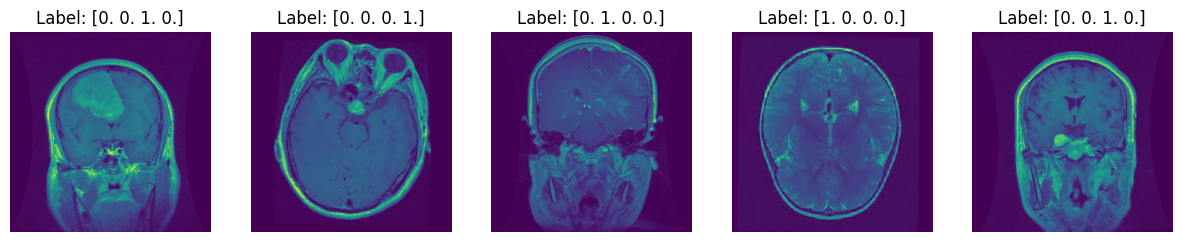

In [33]:
##################################
# Loading samples of augmented images
# for the training set
##################################
##################################
# Loading samples of augmented images
# for the training set
##################################
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    batch = next(train_gen)
    images, labels = batch
    axes[i].imshow(images[0]) 
    axes[i].set_title(f"Label: {labels[0]}")
    axes[i].axis('off')
plt.show()


In [34]:
##################################
# Creating subsets of images
# for model validation
# setting the parameters for
# real-time data augmentation
# at each epoch
##################################
set_seed()
val_datagen = ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2)

##################################
# Loading the model evaluation images
##################################
val_gen = val_datagen.flow_from_directory(directory=path, 
                                            target_size=(299, 299),
                                            class_mode='categorical',
                                            subset='validation',
                                            shuffle=False, 
                                            classes=classes,
                                            batch_size=batch_size, 
                                            color_mode="grayscale")


Found 1141 images belonging to 4 classes.


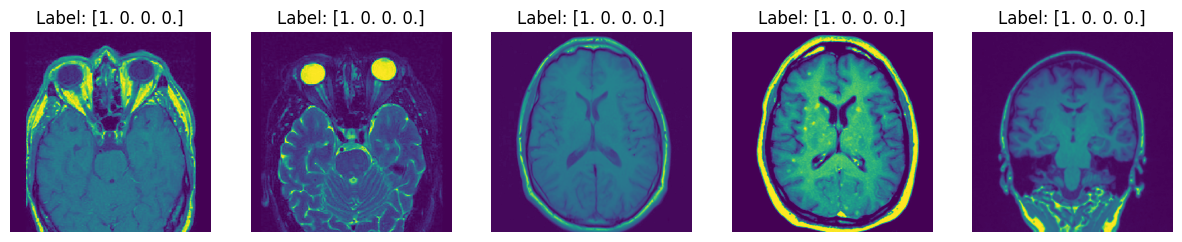

In [35]:
##################################
# Loading samples of original images
# for the validation set
##################################
images, labels = next(val_gen)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, idx in enumerate(range(0, 5)):
    axes[i].imshow(images[idx])
    axes[i].set_title(f"Label: {labels[0]}")
    axes[i].axis('off')
plt.show()


## 1.5 Data Exploration <a class="anchor" id="1.5"></a>

### 1.5.1 Exploratory Data Analysis <a class="anchor" id="1.5.1"></a>

In [36]:
##################################
# Consolidating summary statistics
# for the image pixel values
##################################
mean_val = []
std_dev_val = []
max_val = []
min_val = []

for i in range(0, samples):
    mean_val.append(mri_images['Image'][i].mean())
    std_dev_val.append(np.std(mri_images['Image'][i]))
    max_val.append(mri_images['Image'][i].max())
    min_val.append(mri_images['Image'][i].min())

imageEDA = mri_images.loc[:,['Image', 'Class','Path']]
imageEDA['Mean'] = mean_val
imageEDA['StDev'] = std_dev_val
imageEDA['Max'] = max_val
imageEDA['Min'] = min_val


In [37]:
##################################
# Consolidating the overall mean
# for the pixel intensity means
# grouped by categories
##################################
imageEDA.groupby(['Class'])['Mean'].mean()


Class
Glioma        32.716871
Meningioma    43.487954
No Tumor      60.815724
Pituitary     49.273456
Name: Mean, dtype: float64

In [38]:
##################################
# Consolidating the overall minimum
# for the pixel intensity means
# grouped by categories
##################################
imageEDA.groupby(['Class'])['Mean'].min()


Class
Glioma        13.701850
Meningioma    18.233400
No Tumor       9.770775
Pituitary     24.699575
Name: Mean, dtype: float64

In [39]:
##################################
# Consolidating the overall maximum
# for the pixel intensity means
# grouped by categories
##################################
imageEDA.groupby(['Class'])['Mean'].max()


Class
Glioma         68.372425
Meningioma    137.765375
No Tumor      125.066725
Pituitary     102.007950
Name: Mean, dtype: float64

In [40]:
##################################
# Consolidating the overall standard deviation
# for the pixel intensity means
# grouped by categories
##################################
imageEDA.groupby(['Class'])['Mean'].std()


Class
Glioma         8.565834
Meningioma    14.307165
No Tumor      21.338225
Pituitary      8.222902
Name: Mean, dtype: float64

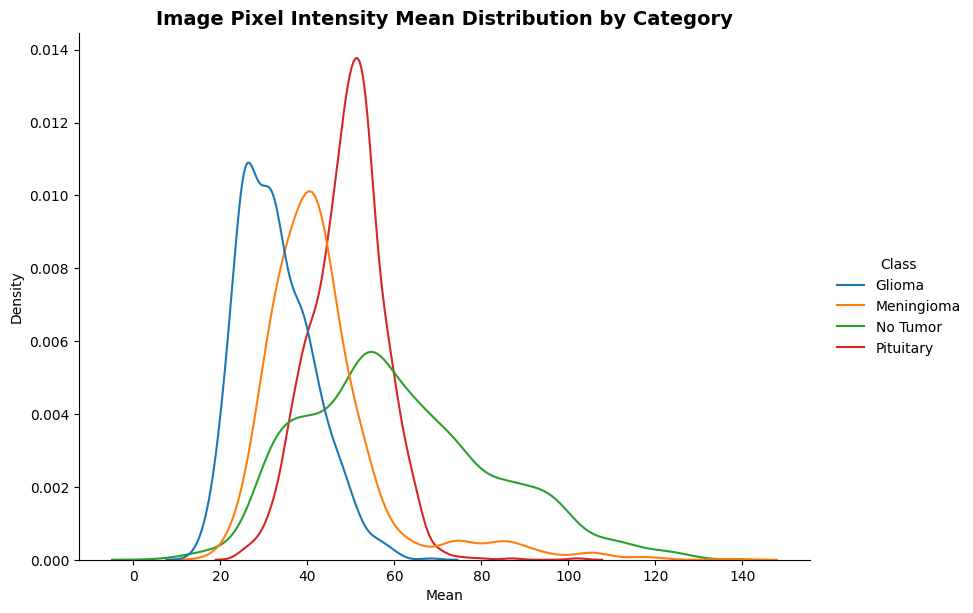

In [41]:
##################################
# Formulating the mean distribution
# by category of the image pixel values
##################################
sns.displot(data = imageEDA, x = 'Mean', kind="kde", hue = 'Class', height=6, aspect=1.40)
plt.title('Image Pixel Intensity Mean Distribution by Category', fontsize=14, weight='bold');


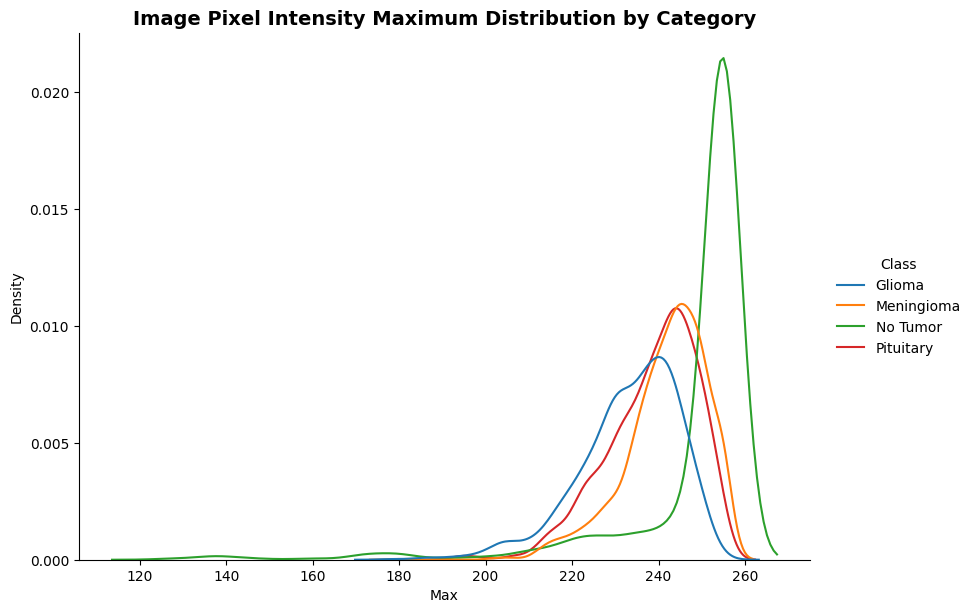

In [42]:
##################################
# Formulating the maximum distribution
# by category of the image pixel values
##################################
sns.displot(data = imageEDA, x = 'Max', kind="kde", hue = 'Class', height=6, aspect=1.40)
plt.title('Image Pixel Intensity Maximum Distribution by Category', fontsize=14, weight='bold');


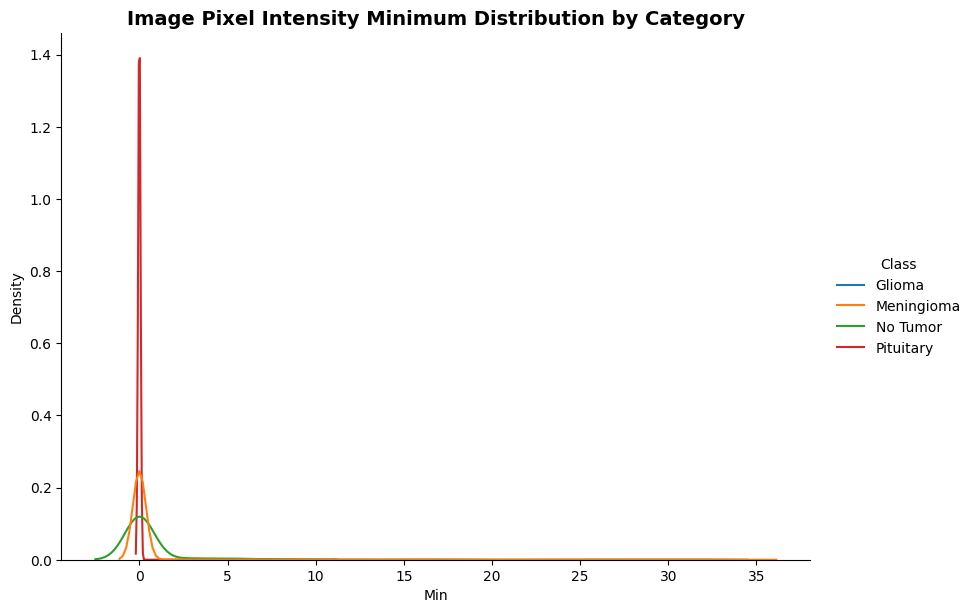

In [43]:
##################################
# Formulating the minimum distribution
# by category of the image pixel values
##################################
sns.displot(data = imageEDA, x = 'Min', kind="kde", hue = 'Class', height=6, aspect=1.40)
plt.title('Image Pixel Intensity Minimum Distribution by Category', fontsize=14, weight='bold');


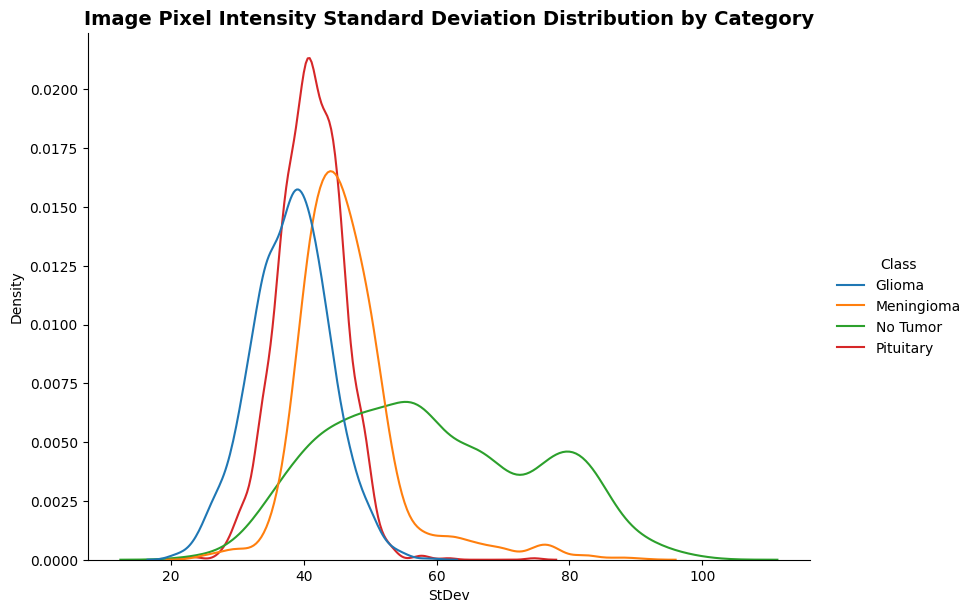

In [44]:
##################################
# Formulating the standard deviation distribution
# by category of the image pixel values
##################################
sns.displot(data = imageEDA, x = 'StDev', kind="kde", hue = 'Class', height=6, aspect=1.40)
plt.title('Image Pixel Intensity Standard Deviation Distribution by Category', fontsize=14, weight='bold');


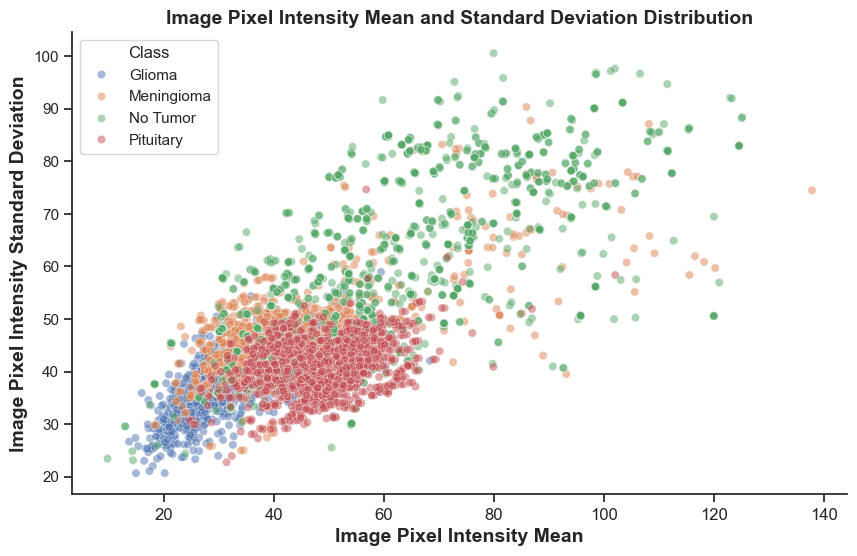

In [45]:
##################################
# Formulating the mean and standard deviation 
# scatterplot distribution
# by category of the image pixel values
##################################
plt.figure(figsize=(10,6))
sns.set(style="ticks", font_scale = 1)
ax = sns.scatterplot(data=imageEDA, x="Mean", y=imageEDA['StDev'], hue='Class', alpha=0.5)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xticks(rotation=0, fontsize = 12)
ax.set_xlabel('Image Pixel Intensity Mean',fontsize=14, weight='bold')
ax.set_ylabel('Image Pixel Intensity Standard Deviation', fontsize=14, weight='bold')
plt.title('Image Pixel Intensity Mean and Standard Deviation Distribution', fontsize = 14, weight='bold');


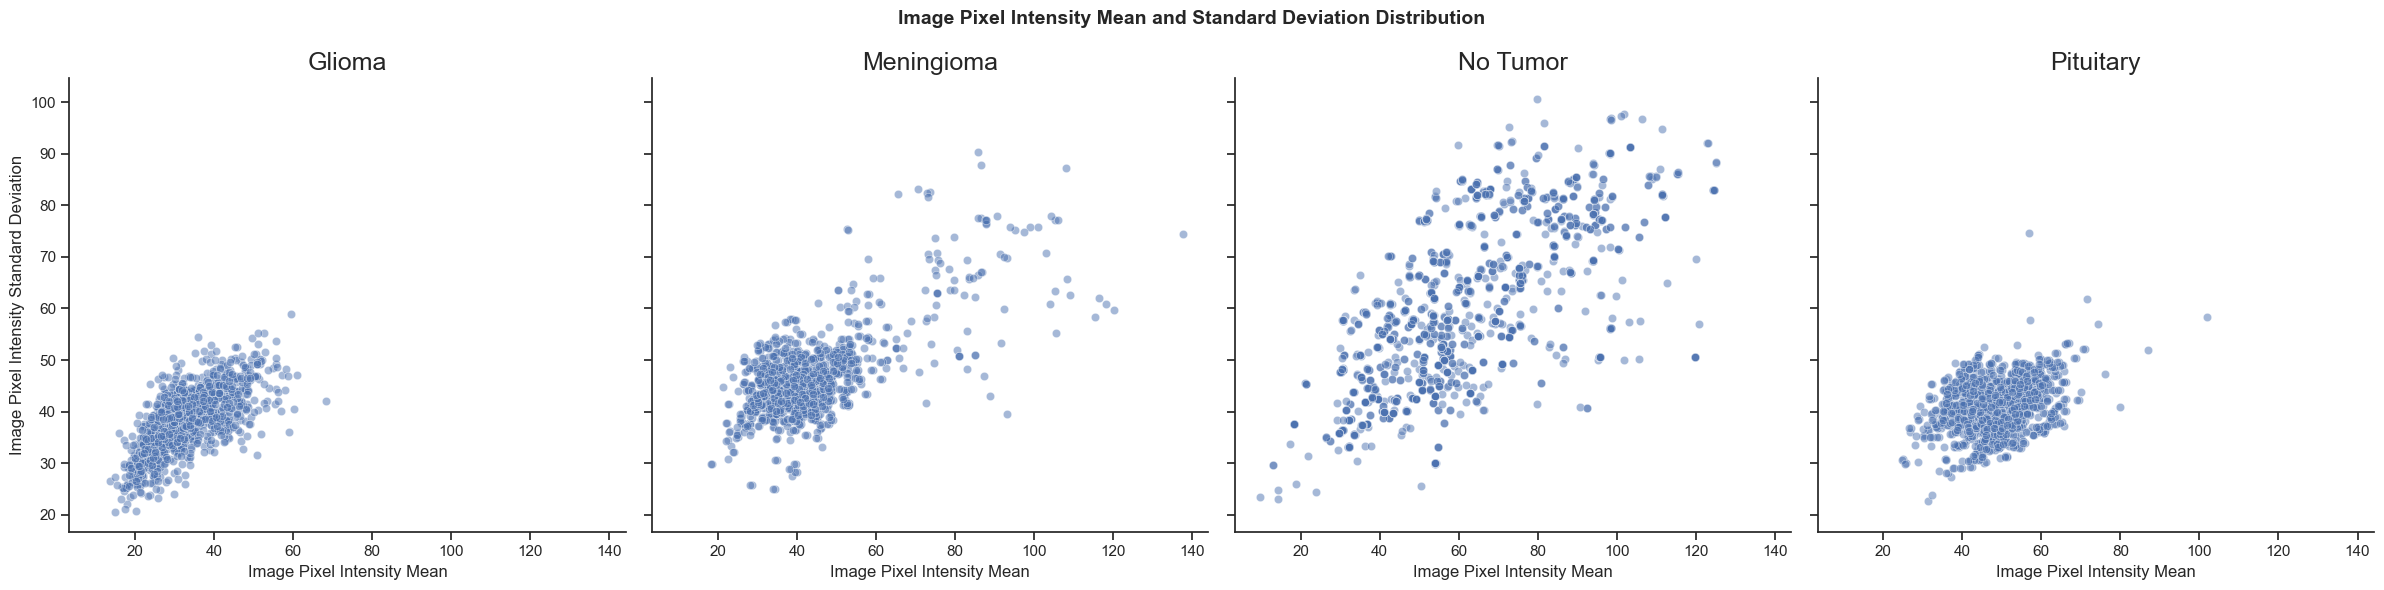

In [46]:
##################################
# Formulating the mean and standard deviation 
# scatterplot distribution
# by category of the image pixel values
##################################
scatterplot = sns.FacetGrid(imageEDA, col="Class", height=6)
scatterplot.map_dataframe(sns.scatterplot, x='Mean', y='StDev', alpha=0.5)
scatterplot.set_titles(col_template="{col_name}", row_template="{row_name}", size=18)
scatterplot.fig.subplots_adjust(top=.8)
scatterplot.fig.suptitle('Image Pixel Intensity Mean and Standard Deviation Distribution', fontsize=14, weight='bold')
axes = scatterplot.axes.flatten()
axes[0].set_ylabel('Image Pixel Intensity Standard Deviation')
for ax in axes:
    ax.set_xlabel('Image Pixel Intensity Mean')
scatterplot.fig.tight_layout()


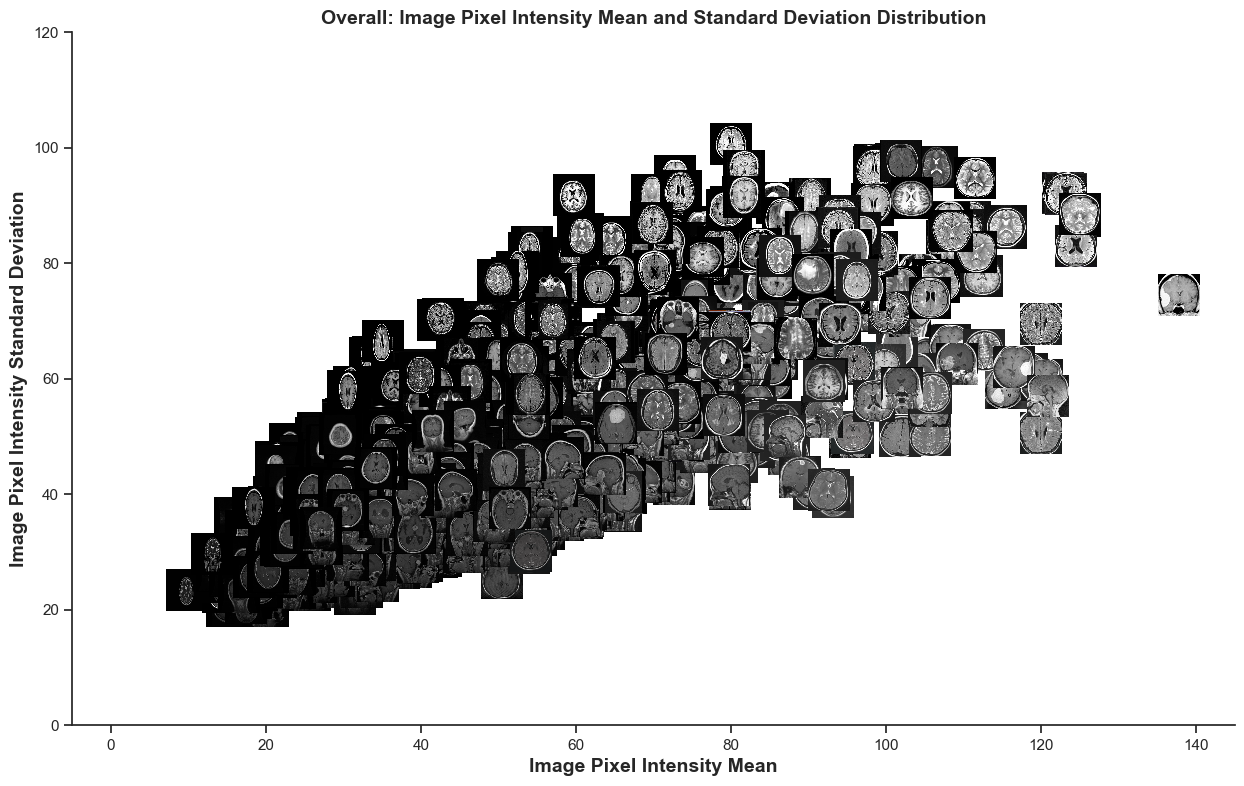

In [47]:
##################################
# Formulating the mean and standard deviation 
# scatterplot distribution
# of the image pixel values
# represented as actual images
##################################
def getImage(path):
    image = cv2.imread(path)
    resized_image = cv2.resize(image, (300,300))
    return OffsetImage(resized_image, zoom = 0.1)

DF_sample = imageEDA.sample(frac=1.0, replace=False, random_state=123)
paths = DF_sample['Path']

fig, ax = plt.subplots(figsize=(15,9))
ab = sns.scatterplot(data=DF_sample, x="Mean", y='StDev')
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_xlabel('Image Pixel Intensity Mean', fontsize=14, weight='bold')
ax.set_ylabel('Image Pixel Intensity Standard Deviation', fontsize=14, weight='bold')
ax.set_xlim(-5,145)
ax.set_ylim(0,120)
plt.title('Overall: Image Pixel Intensity Mean and Standard Deviation Distribution', fontsize=14, weight='bold');

for x0, y0, path in zip(DF_sample['Mean'], DF_sample['StDev'], paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)
    

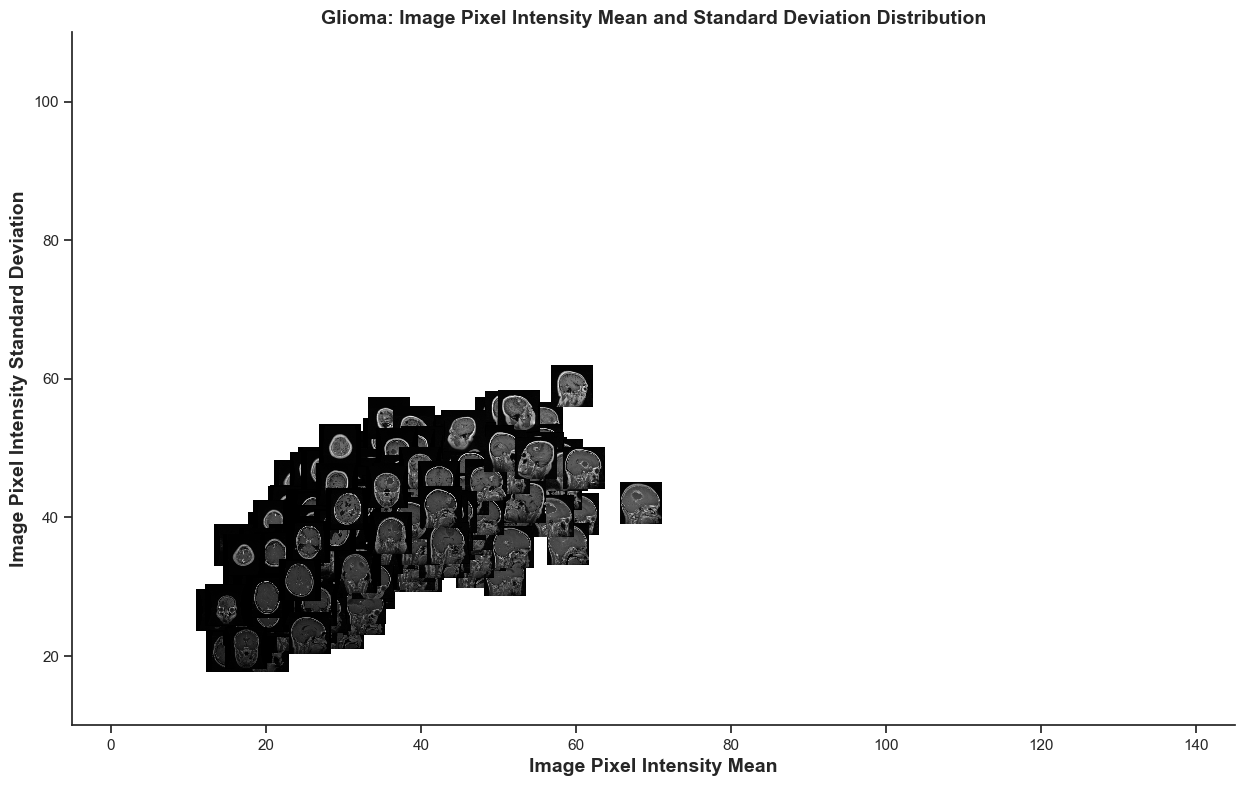

In [48]:
##################################
# Formulating the mean and standard deviation 
# scatterplot distribution
# of the image pixel values
# represented as actual images
# for the Glioma class
##################################
path_glioma = (os.path.join("..", DATASETS_FINAL_TRAIN_PATH,'glioma/'))
imageEDA_glioma = imageEDA.loc[imageEDA['Class'] == 'Glioma']

DF_sample = imageEDA_glioma.sample(frac=1.0, replace=False, random_state=123)
paths = DF_sample['Path']

fig, ax = plt.subplots(figsize=(15,9))
ab = sns.scatterplot(data=DF_sample, x="Mean", y='StDev')
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_xlabel('Image Pixel Intensity Mean', fontsize=14, weight='bold')
ax.set_ylabel('Image Pixel Intensity Standard Deviation', fontsize=14, weight='bold')
ax.set_xlim(-5,145)
ax.set_ylim(10,110)
plt.title('Glioma: Image Pixel Intensity Mean and Standard Deviation Distribution', fontsize=14, weight='bold');

for x0, y0, path_glioma in zip(DF_sample['Mean'], DF_sample['StDev'], paths):
    ab = AnnotationBbox(getImage(path_glioma), (x0, y0), frameon=False)
    ax.add_artist(ab)
    

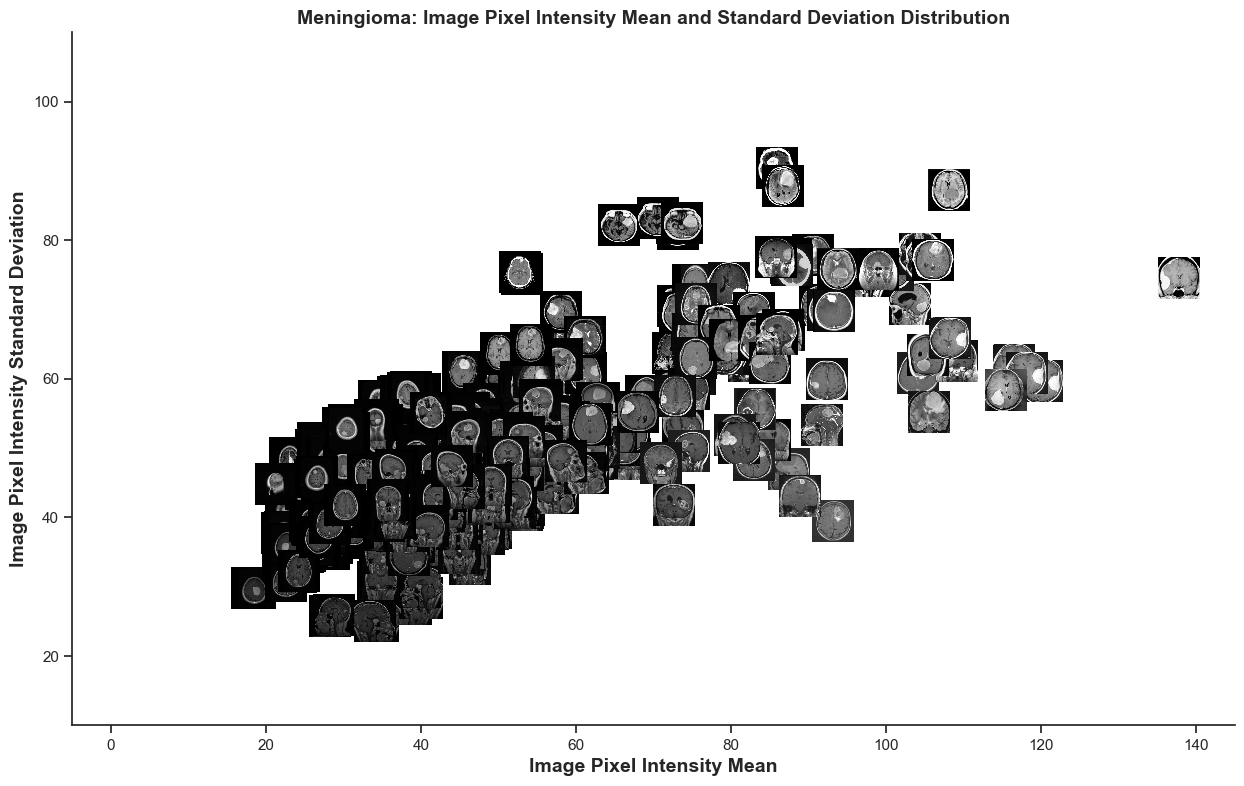

In [49]:
##################################
# Formulating the mean and standard deviation 
# scatterplot distribution
# of the image pixel values
# represented as actual images
# for the Viral Pneumonia class
##################################
path_meningioma = (os.path.join("..", DATASETS_FINAL_TRAIN_PATH,'meningioma/'))
imageEDA_meningioma = imageEDA.loc[imageEDA['Class'] == 'Meningioma']

DF_sample = imageEDA_meningioma.sample(frac=1.0, replace=False, random_state=123)
paths = DF_sample['Path']

fig, ax = plt.subplots(figsize=(15,9))
ab = sns.scatterplot(data=DF_sample, x="Mean", y='StDev')
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_xlabel('Image Pixel Intensity Mean', fontsize=14, weight='bold')
ax.set_ylabel('Image Pixel Intensity Standard Deviation', fontsize=14, weight='bold')
ax.set_xlim(-5,145)
ax.set_ylim(10,110)
plt.title('Meningioma: Image Pixel Intensity Mean and Standard Deviation Distribution', fontsize=14, weight='bold');

for x0, y0, path_meningioma in zip(DF_sample['Mean'], DF_sample['StDev'], paths):
    ab = AnnotationBbox(getImage(path_meningioma), (x0, y0), frameon=False)
    ax.add_artist(ab)
    

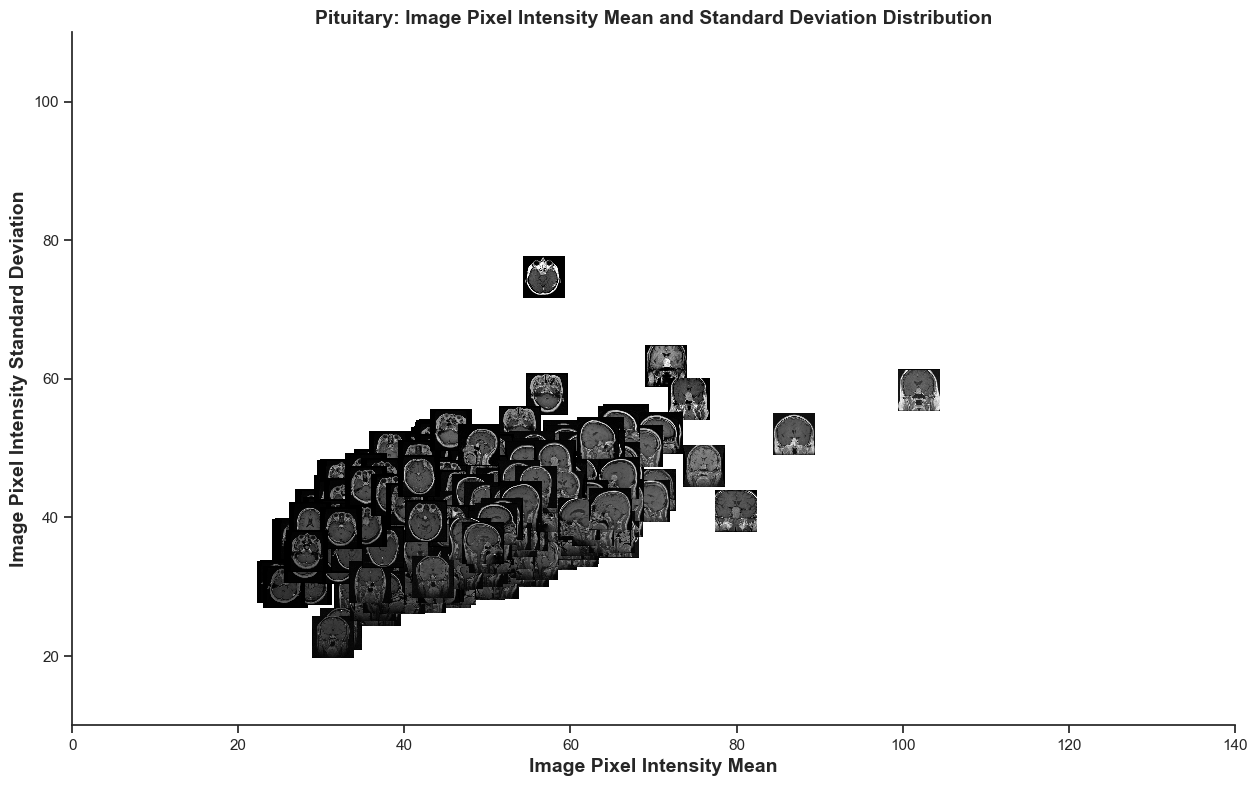

In [50]:
##################################
# Formulating the mean and standard deviation 
# scatterplot distribution
# of the image pixel values
# represented as actual images
# for the Pituitary class
##################################
path_pituitary = (os.path.join("..", DATASETS_FINAL_TRAIN_PATH,'pituitary/'))
imageEDA_pituitary = imageEDA.loc[imageEDA['Class'] == 'Pituitary']

DF_sample = imageEDA_pituitary.sample(frac=1.0, replace=False, random_state=123)
paths = DF_sample['Path']

fig, ax = plt.subplots(figsize=(15,9))
ab = sns.scatterplot(data=DF_sample, x="Mean", y='StDev')
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_xlabel('Image Pixel Intensity Mean', fontsize=14, weight='bold')
ax.set_ylabel('Image Pixel Intensity Standard Deviation', fontsize=14, weight='bold')
ax.set_xlim(0, 140)
ax.set_ylim(10,110)
plt.title('Pituitary: Image Pixel Intensity Mean and Standard Deviation Distribution', fontsize=14, weight='bold');

for x0, y0, path_pituitary in zip(DF_sample['Mean'], DF_sample['StDev'], paths):
    ab = AnnotationBbox(getImage(path_pituitary), (x0, y0), frameon=False)
    ax.add_artist(ab)
    

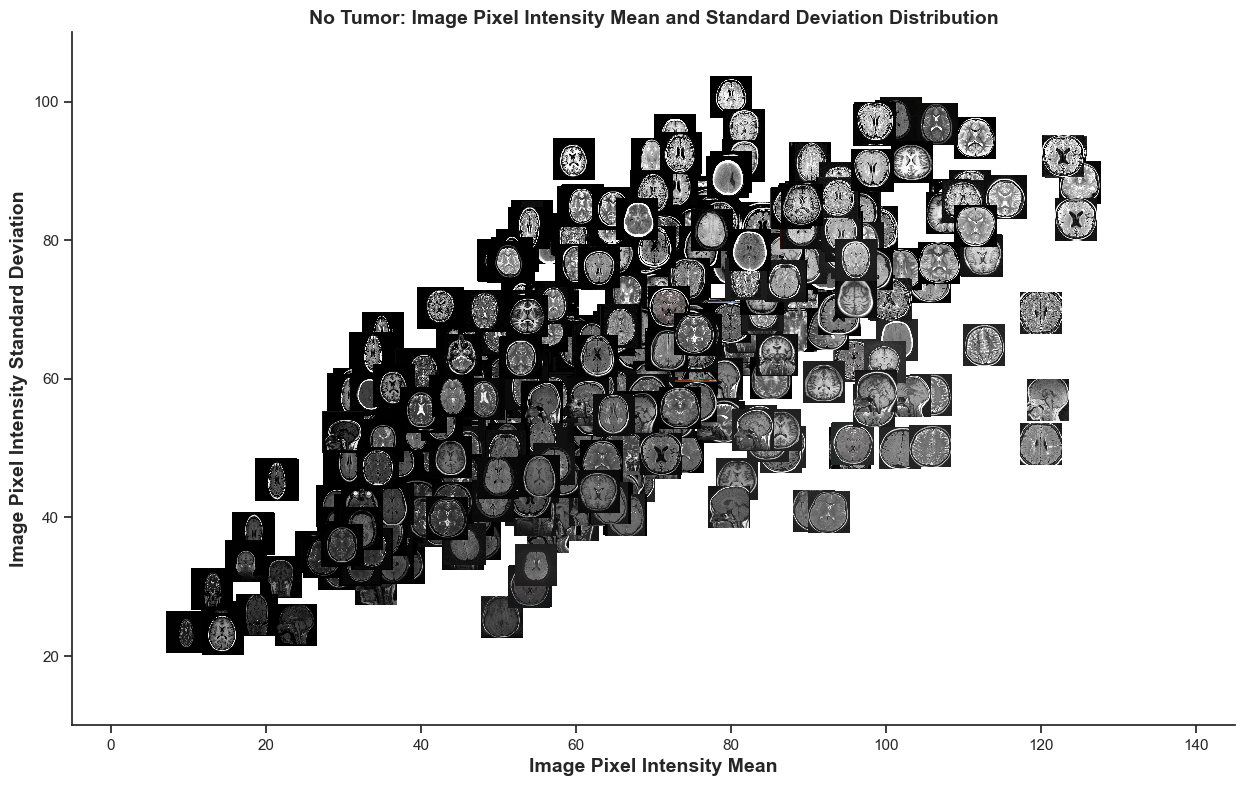

In [51]:
##################################
# Formulating the mean and standard deviation 
# scatterplot distribution
# of the image pixel values
# represented as actual images
# for the No Tumor class
##################################
path_no_tumor = (os.path.join("..", DATASETS_FINAL_TRAIN_PATH,'notumor/'))
imageEDA_no_tumor = imageEDA.loc[imageEDA['Class'] == 'No Tumor']

DF_sample = imageEDA_no_tumor.sample(frac=1.0, replace=False, random_state=123)
paths = DF_sample['Path']

fig, ax = plt.subplots(figsize=(15,9))
ab = sns.scatterplot(data=DF_sample, x="Mean", y='StDev')
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_xlabel('Image Pixel Intensity Mean', fontsize=14, weight='bold')
ax.set_ylabel('Image Pixel Intensity Standard Deviation', fontsize=14, weight='bold')
ax.set_xlim(-5,145)
ax.set_ylim(10,110)
plt.title('No Tumor: Image Pixel Intensity Mean and Standard Deviation Distribution', fontsize=14, weight='bold');

for x0, y0, path_no_tumor in zip(DF_sample['Mean'], DF_sample['StDev'], paths):
    ab = AnnotationBbox(getImage(path_no_tumor), (x0, y0), frameon=False)
    ax.add_artist(ab)
    

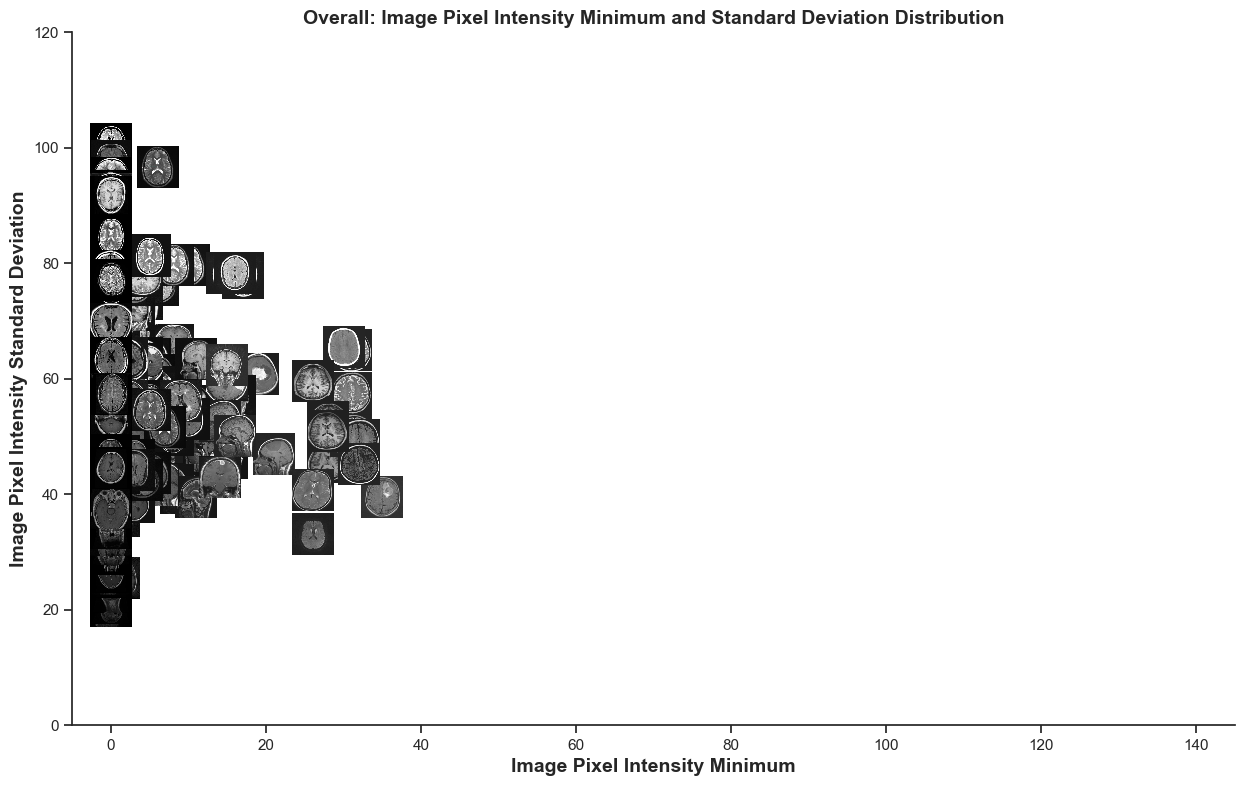

In [52]:
#################################
# Formulating the minimum and standard deviation 
# scatterplot distribution
# of the image pixel values
# represented as actual images
##################################
DF_sample = imageEDA.sample(frac=1.0, replace=False, random_state=123)
paths = DF_sample['Path']

fig, ax = plt.subplots(figsize=(15,9))
ab = sns.scatterplot(data=DF_sample, x="Min", y='StDev')
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_xlabel('Image Pixel Intensity Minimum', fontsize=14, weight='bold')
ax.set_ylabel('Image Pixel Intensity Standard Deviation', fontsize=14, weight='bold')
ax.set_xlim(-5,145)
ax.set_ylim(0,120)
plt.title('Overall: Image Pixel Intensity Minimum and Standard Deviation Distribution', fontsize=14, weight='bold');

for x0, y0, path in zip(DF_sample['Min'], DF_sample['StDev'], paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)
    

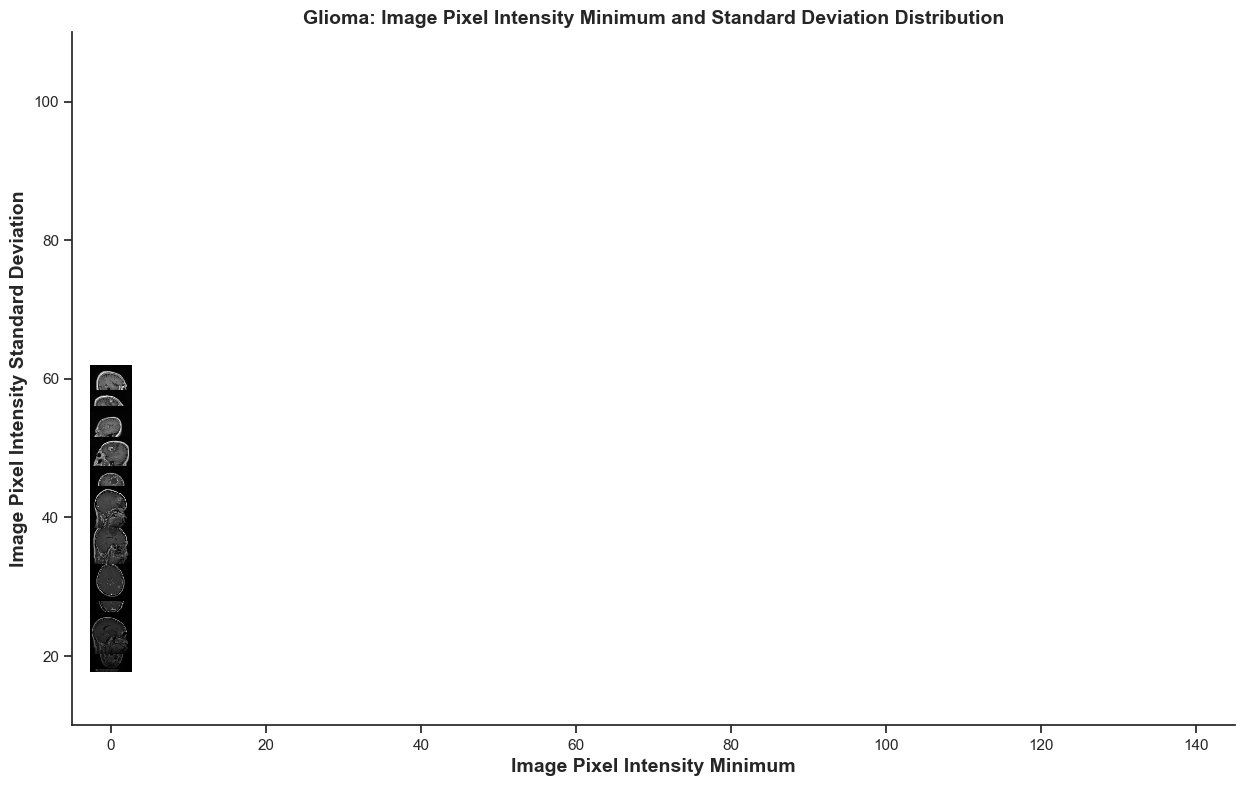

In [53]:
##################################
# Formulating the minimum and standard deviation 
# scatterplot distribution
# of the image pixel values
# represented as actual images
# for the Glioma class
##################################
DF_sample = imageEDA_glioma.sample(frac=1.0, replace=False, random_state=123)
paths = DF_sample['Path']

fig, ax = plt.subplots(figsize=(15,9))
ab = sns.scatterplot(data=DF_sample, x="Min", y='StDev')
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_xlabel('Image Pixel Intensity Minimum', fontsize=14, weight='bold')
ax.set_ylabel('Image Pixel Intensity Standard Deviation', fontsize=14, weight='bold')
ax.set_xlim(-5,145)
ax.set_ylim(10,110)
plt.title('Glioma: Image Pixel Intensity Minimum and Standard Deviation Distribution', fontsize=14, weight='bold');

for x0, y0, path_glioma in zip(DF_sample['Min'], DF_sample['StDev'], paths):
    ab = AnnotationBbox(getImage(path_glioma), (x0, y0), frameon=False)
    ax.add_artist(ab)
    

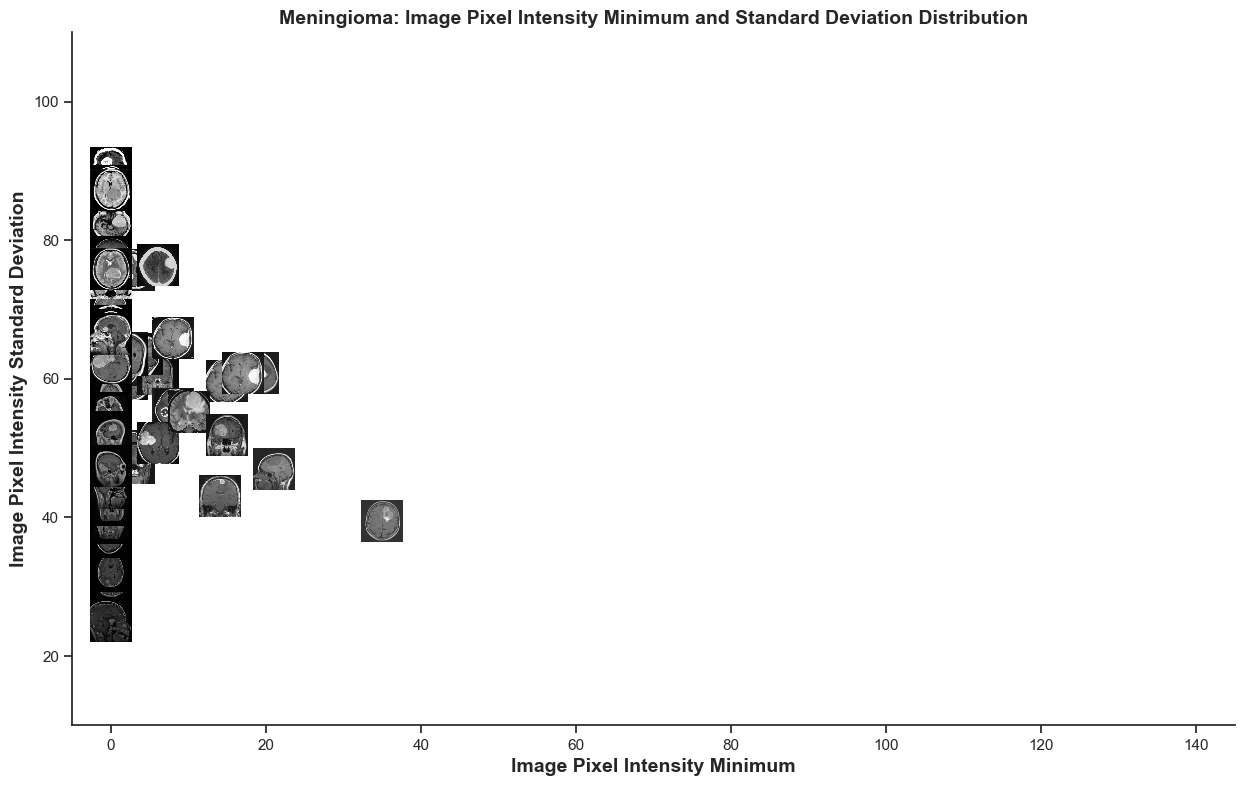

In [54]:
##################################
# Formulating the minimum and standard deviation 
# scatterplot distribution
# of the image pixel values
# represented as actual images
# for the Meningioma class
##################################
DF_sample = imageEDA_meningioma.sample(frac=1.0, replace=False, random_state=123)
paths = DF_sample['Path']

fig, ax = plt.subplots(figsize=(15,9))
ab = sns.scatterplot(data=DF_sample, x="Min", y='StDev')
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_xlabel('Image Pixel Intensity Minimum', fontsize=14, weight='bold')
ax.set_ylabel('Image Pixel Intensity Standard Deviation', fontsize=14, weight='bold')
ax.set_xlim(-5,145)
ax.set_ylim(10,110)
plt.title('Meningioma: Image Pixel Intensity Minimum and Standard Deviation Distribution', fontsize=14, weight='bold');

for x0, y0, path_meningioma in zip(DF_sample['Min'], DF_sample['StDev'], paths):
    ab = AnnotationBbox(getImage(path_meningioma), (x0, y0), frameon=False)
    ax.add_artist(ab)


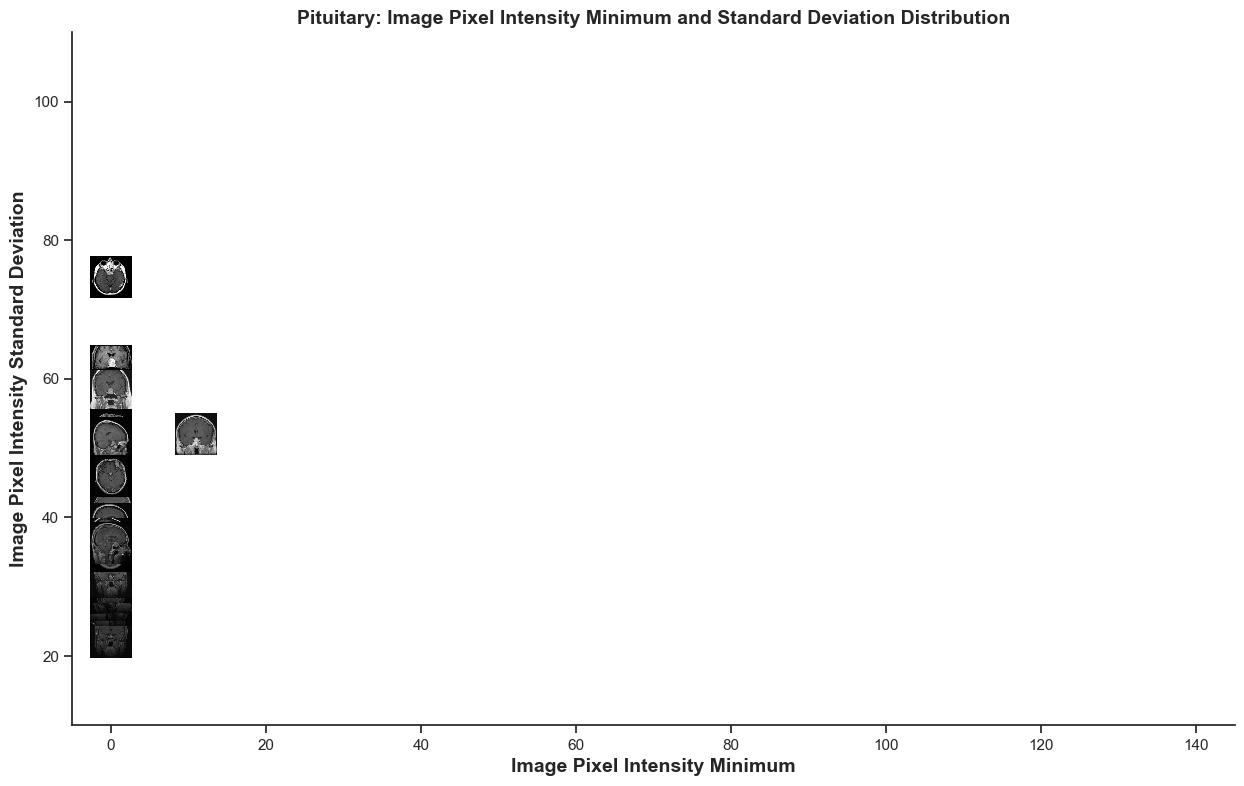

In [55]:
##################################
# Formulating the minimum and standard deviation 
# scatterplot distribution
# of the image pixel values
# represented as actual images
# for the Pituitary class
##################################
DF_sample = imageEDA_pituitary.sample(frac=1.0, replace=False, random_state=123)
paths = DF_sample['Path']

fig, ax = plt.subplots(figsize=(15,9))
ab = sns.scatterplot(data=DF_sample, x="Min", y='StDev')
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_xlabel('Image Pixel Intensity Minimum', fontsize=14, weight='bold')
ax.set_ylabel('Image Pixel Intensity Standard Deviation', fontsize=14, weight='bold')
ax.set_xlim(-5,145)
ax.set_ylim(10,110)
plt.title('Pituitary: Image Pixel Intensity Minimum and Standard Deviation Distribution', fontsize=14, weight='bold');

for x0, y0, path_pituitary in zip(DF_sample['Min'], DF_sample['StDev'], paths):
    ab = AnnotationBbox(getImage(path_pituitary), (x0, y0), frameon=False)
    ax.add_artist(ab)


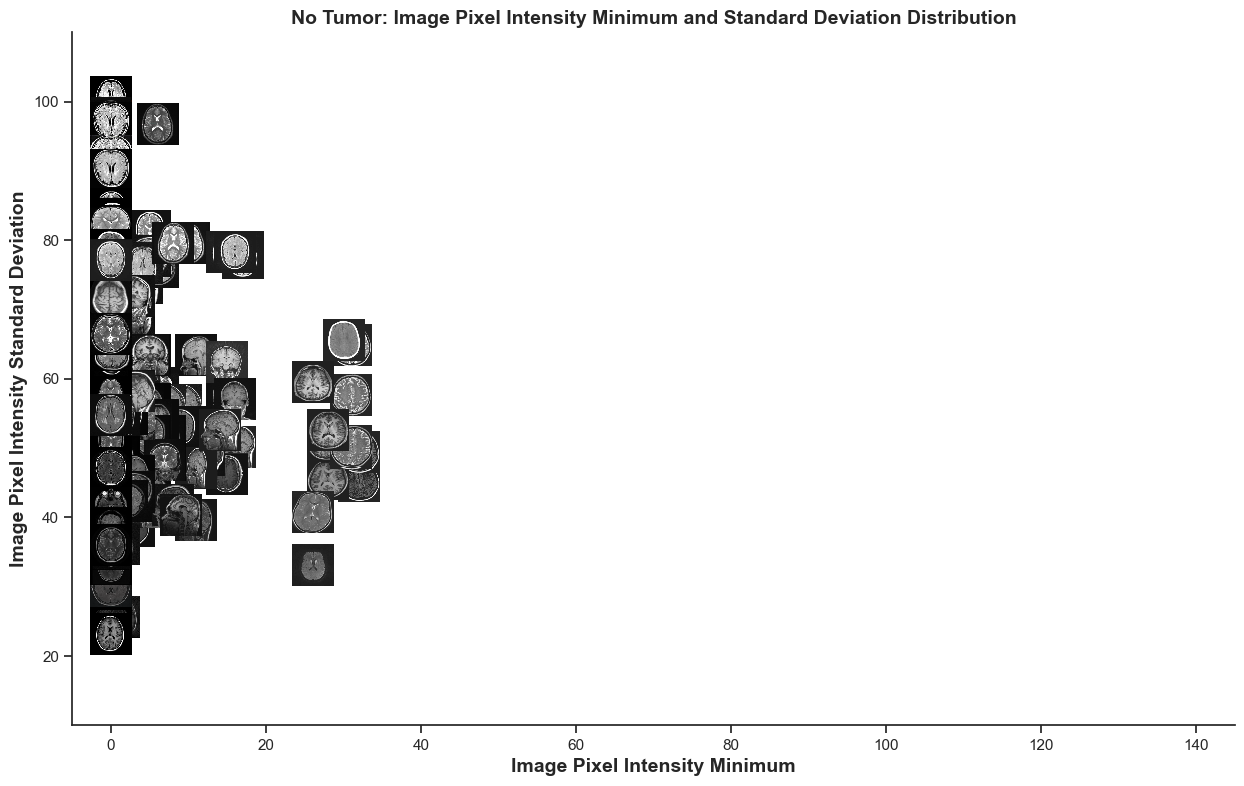

In [56]:
##################################
# Formulating the minimum and standard deviation 
# scatterplot distribution
# of the image pixel values
# represented as actual images
# for the No Tumor class
##################################
DF_sample = imageEDA_no_tumor.sample(frac=1.0, replace=False, random_state=123)
paths = DF_sample['Path']

fig, ax = plt.subplots(figsize=(15,9))
ab = sns.scatterplot(data=DF_sample, x="Min", y='StDev')
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_xlabel('Image Pixel Intensity Minimum', fontsize=14, weight='bold')
ax.set_ylabel('Image Pixel Intensity Standard Deviation', fontsize=14, weight='bold')
ax.set_xlim(-5,145)
ax.set_ylim(10,110)
plt.title('No Tumor: Image Pixel Intensity Minimum and Standard Deviation Distribution', fontsize=14, weight='bold');

for x0, y0, path_no_tumor in zip(DF_sample['Min'], DF_sample['StDev'], paths):
    ab = AnnotationBbox(getImage(path_no_tumor), (x0, y0), frameon=False)
    ax.add_artist(ab)


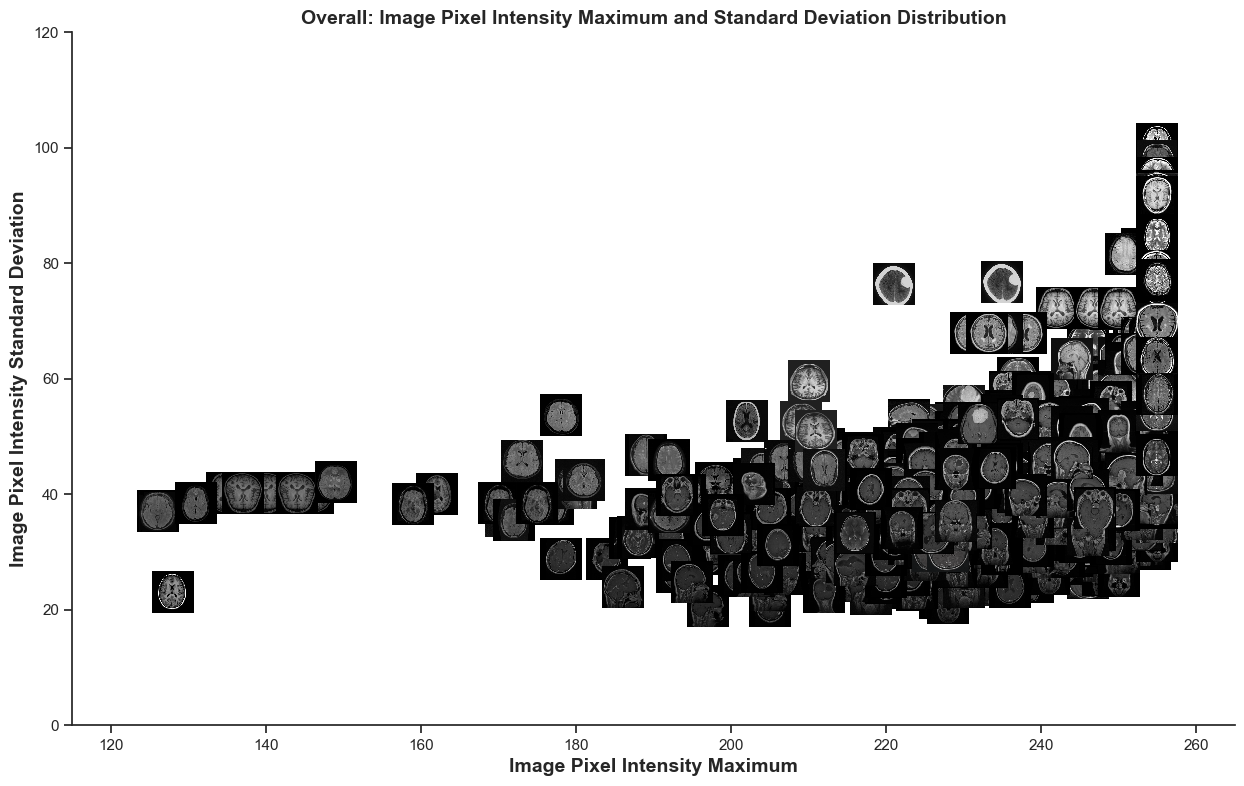

In [57]:
#################################
# Formulating the maximum and standard deviation 
# scatterplot distribution
# of the image pixel values
# represented as actual images
##################################
DF_sample = imageEDA.sample(frac=1.0, replace=False, random_state=123)
paths = DF_sample['Path']

fig, ax = plt.subplots(figsize=(15,9))
ab = sns.scatterplot(data=DF_sample, x="Max", y='StDev')
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_xlabel('Image Pixel Intensity Maximum', fontsize=14, weight='bold')
ax.set_ylabel('Image Pixel Intensity Standard Deviation', fontsize=14, weight='bold')
ax.set_xlim(115,265)
ax.set_ylim(0,120)
plt.title('Overall: Image Pixel Intensity Maximum and Standard Deviation Distribution', fontsize=14, weight='bold');

for x0, y0, path in zip(DF_sample['Max'], DF_sample['StDev'], paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)

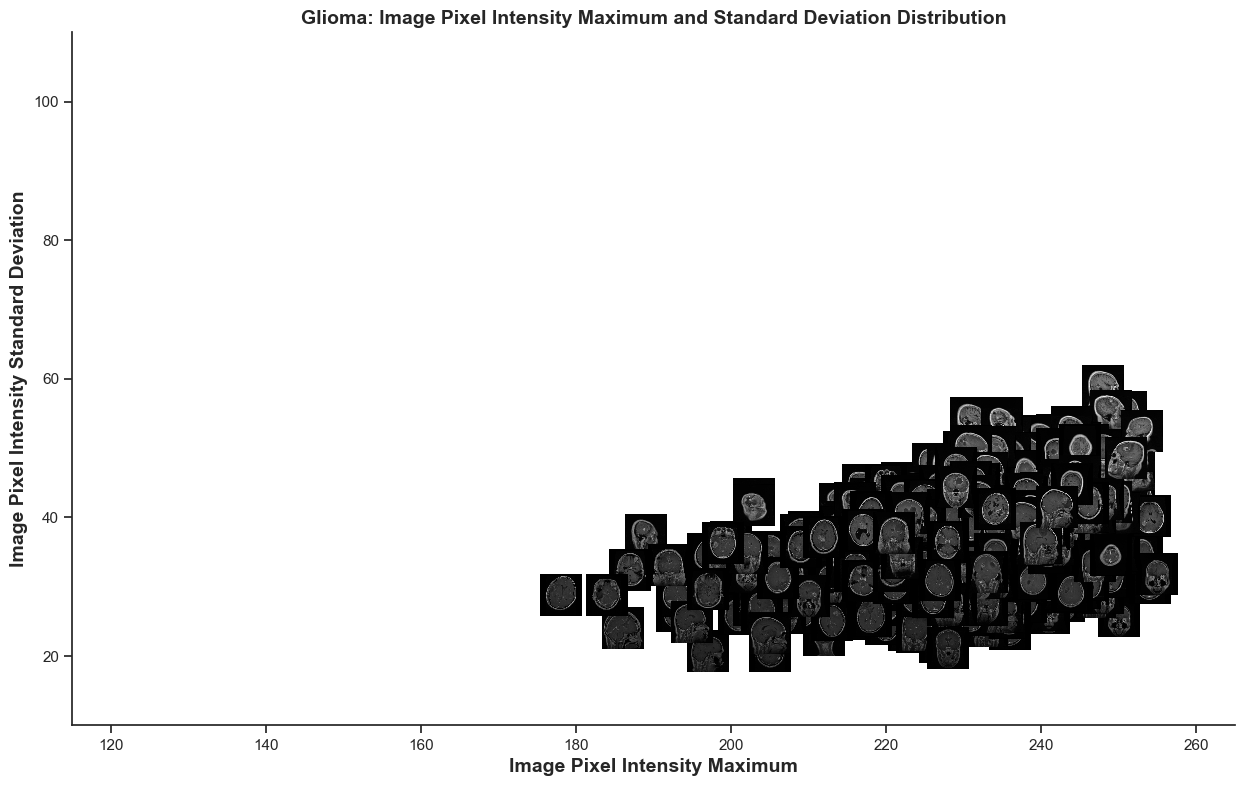

In [58]:
##################################
# Formulating the maximum and standard deviation 
# scatterplot distribution
# of the image pixel values
# represented as actual images
# for the Glioma class
##################################
DF_sample = imageEDA_glioma.sample(frac=1.0, replace=False, random_state=123)
paths = DF_sample['Path']

fig, ax = plt.subplots(figsize=(15,9))
ab = sns.scatterplot(data=DF_sample, x="Max", y='StDev')
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_xlabel('Image Pixel Intensity Maximum', fontsize=14, weight='bold')
ax.set_ylabel('Image Pixel Intensity Standard Deviation', fontsize=14, weight='bold')
ax.set_xlim(115,265)
ax.set_ylim(10,110)
plt.title('Glioma: Image Pixel Intensity Maximum and Standard Deviation Distribution', fontsize=14, weight='bold');

for x0, y0, path_glioma in zip(DF_sample['Max'], DF_sample['StDev'], paths):
    ab = AnnotationBbox(getImage(path_glioma), (x0, y0), frameon=False)
    ax.add_artist(ab)

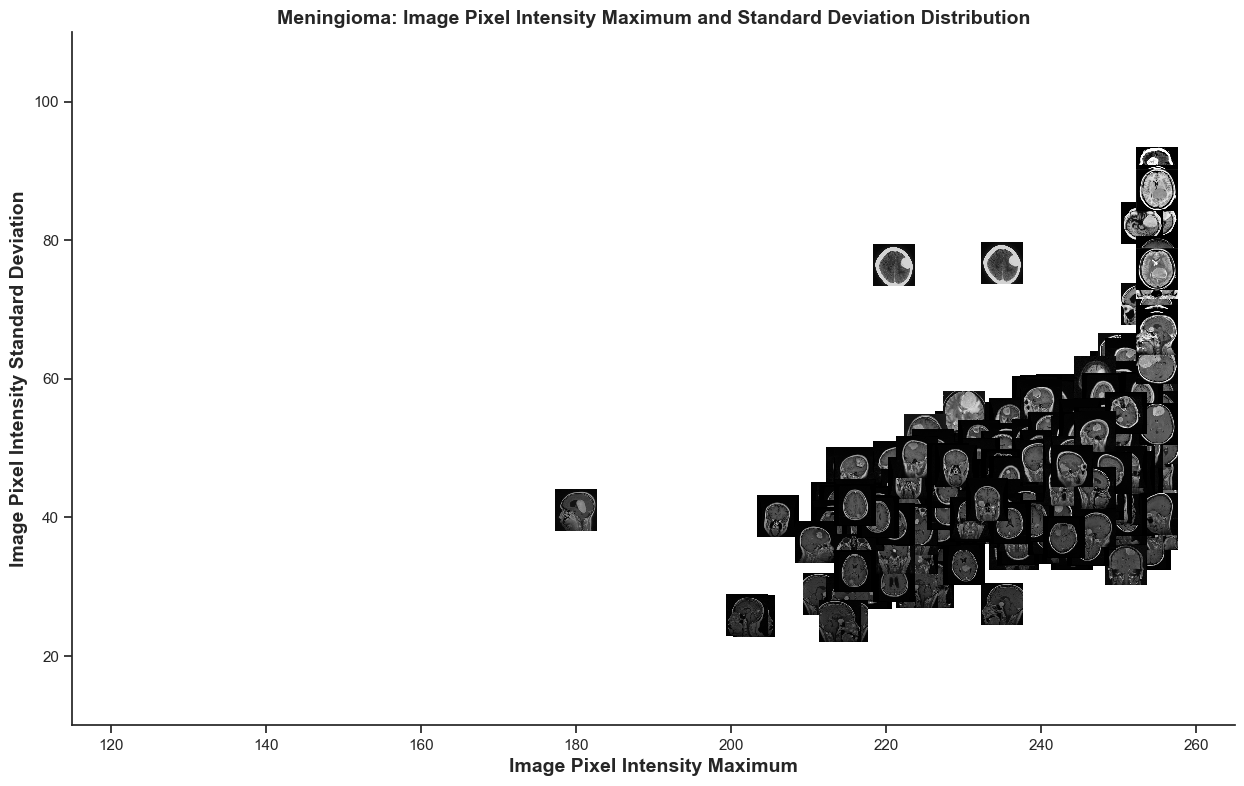

In [59]:
##################################
# Formulating the maximum and standard deviation 
# scatterplot distribution
# of the image pixel values
# represented as actual images
# for the Meningioma class
##################################
DF_sample = imageEDA_meningioma.sample(frac=1.0, replace=False, random_state=123)
paths = DF_sample['Path']

fig, ax = plt.subplots(figsize=(15,9))
ab = sns.scatterplot(data=DF_sample, x="Max", y='StDev')
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_xlabel('Image Pixel Intensity Maximum', fontsize=14, weight='bold')
ax.set_ylabel('Image Pixel Intensity Standard Deviation', fontsize=14, weight='bold')
ax.set_xlim(115,265)
ax.set_ylim(10,110)
plt.title('Meningioma: Image Pixel Intensity Maximum and Standard Deviation Distribution', fontsize=14, weight='bold');

for x0, y0, path_meningioma in zip(DF_sample['Max'], DF_sample['StDev'], paths):
    ab = AnnotationBbox(getImage(path_meningioma), (x0, y0), frameon=False)
    ax.add_artist(ab)


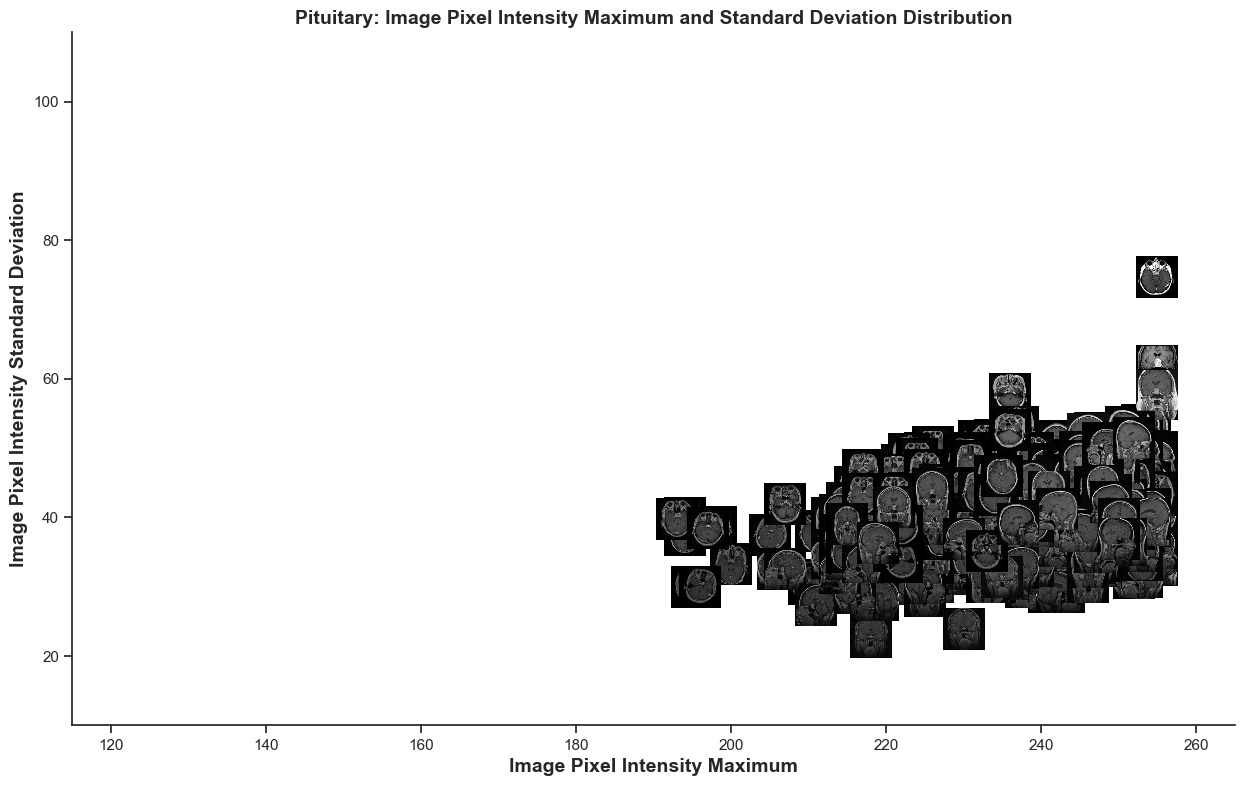

In [60]:
##################################
# Formulating the maximum and standard deviation 
# scatterplot distribution
# of the image pixel values
# represented as actual images
# for the Pituitary class
##################################
DF_sample = imageEDA_pituitary.sample(frac=1.0, replace=False, random_state=123)
paths = DF_sample['Path']

fig, ax = plt.subplots(figsize=(15,9))
ab = sns.scatterplot(data=DF_sample, x="Max", y='StDev')
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_xlabel('Image Pixel Intensity Maximum', fontsize=14, weight='bold')
ax.set_ylabel('Image Pixel Intensity Standard Deviation', fontsize=14, weight='bold')
ax.set_xlim(115,265)
ax.set_ylim(10,110)
plt.title('Pituitary: Image Pixel Intensity Maximum and Standard Deviation Distribution', fontsize=14, weight='bold');

for x0, y0, path_pituitary in zip(DF_sample['Max'], DF_sample['StDev'], paths):
    ab = AnnotationBbox(getImage(path_pituitary), (x0, y0), frameon=False)
    ax.add_artist(ab)


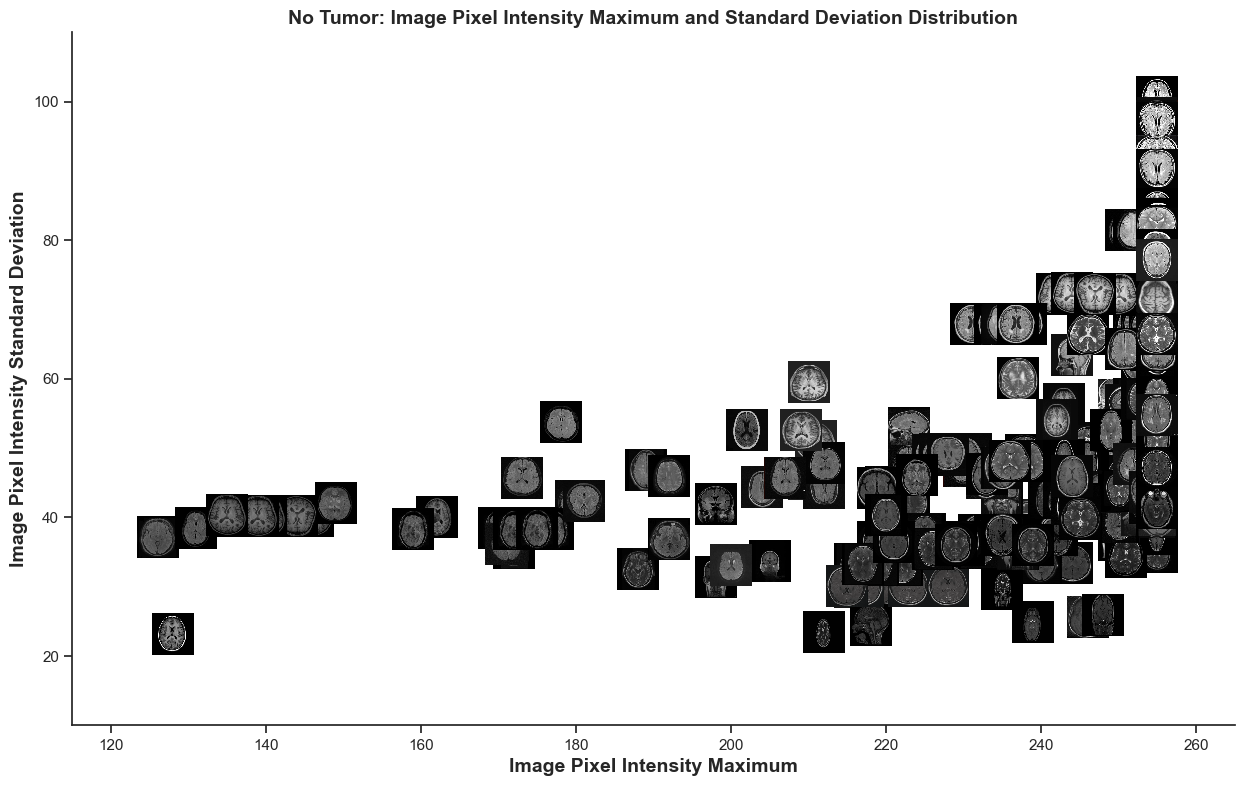

In [61]:
##################################
# Formulating the maximum and standard deviation 
# scatterplot distribution
# of the image pixel values
# represented as actual images
# for the No Tumor class
##################################
DF_sample = imageEDA_no_tumor.sample(frac=1.0, replace=False, random_state=123)
paths = DF_sample['Path']

fig, ax = plt.subplots(figsize=(15,9))
ab = sns.scatterplot(data=DF_sample, x="Max", y='StDev')
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_xlabel('Image Pixel Intensity Maximum', fontsize=14, weight='bold')
ax.set_ylabel('Image Pixel Intensity Standard Deviation', fontsize=14, weight='bold')
ax.set_xlim(115,265)
ax.set_ylim(10,110)
plt.title('No Tumor: Image Pixel Intensity Maximum and Standard Deviation Distribution', fontsize=14, weight='bold');

for x0, y0, path_no_tumor in zip(DF_sample['Max'], DF_sample['StDev'], paths):
    ab = AnnotationBbox(getImage(path_no_tumor), (x0, y0), frameon=False)
    ax.add_artist(ab)


### 1.5.2 Hypothesis Testing <a class="anchor" id="1.5.2"></a>

## 1.6 Predictive Model Development <a class="anchor" id="1.6"></a>

### 1.6.1 Pre-Modelling Data Preparation <a class="anchor" id="1.6.1"></a>

### 1.6.2 Data Splitting <a class="anchor" id="1.6.2"></a>

### 1.6.3 Convolutional Neural Network Sequential Layer Development <a class="anchor" id="1.6.3"></a>

#### 1.6.3.1 CNN With No Regularization <a class="anchor" id="1.6.3.1"></a>

In [62]:
##################################
# Defining a function for
# plotting the loss profile
# of the training and validation sets
#################################
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 8))
    
    # Plotting training and validation loss
    plt.subplot(2, 1, 1)  # First subplot for loss
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'{model_name} Training and Validation Loss', fontsize=16, weight='bold', pad=20)
    plt.ylim(0, max(max(history.history['loss']), max(history.history['val_loss'])) * 1.1)
    plt.xlabel('Epoch', fontsize=14, weight='bold')
    plt.ylabel('Loss', fontsize=14, weight='bold')
    plt.legend(loc='upper right')
    plt.grid(True)
    
    # Plotting training and validation recall
    plt.subplot(2, 1, 2)  # Second subplot for recall
    plt.plot(history.history['recall'], label='Train Recall', color='green')
    plt.plot(history.history['val_recall'], label='Validation Recall', color='red')
    plt.title(f'{model_name} Training and Validation Recall', fontsize=16, weight='bold', pad=20)
    plt.ylim(0, 1.1)  # Recall is typically between 0 and 1
    plt.xlabel('Epoch', fontsize=14, weight='bold')
    plt.ylabel('Recall', fontsize=14, weight='bold')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    # Adjusting layout and show the plots
    plt.tight_layout(pad=2.0)
    plt.show()

In [63]:
##################################
# Formulating the network architecture
# for CNN with no regularization
##################################
set_seed()
batch_size = 32
model_nr = Sequential()
model_nr.add(Conv2D(filters=32, kernel_size=(7, 7), activation='relu', padding='Same', input_shape=(299, 299, 1)))
model_nr.add(MaxPooling2D(pool_size=(2, 2)))
model_nr.add(Conv2D(filters=64, kernel_size=(7, 7), activation='relu', padding='Same'))
model_nr.add(MaxPooling2D(pool_size=(2, 2)))
model_nr.add(Flatten())
model_nr.add(Dense(units=128, activation='relu'))
model_nr.add(Dense(units=num_classes, activation='softmax'))

##################################
# Compiling the network layers
##################################
optimizer = Adam(learning_rate=0.001)
model_nr.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[Recall()])

In [64]:
##################################
# Displaying the model summary
# for CNN with no regularization
##################################
print(model_nr.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 299, 299, 32)        │           1,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 149, 149, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 149, 149, 64)        │         100,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 350464)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      44,859,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,962,052 (171.52 MB)

 Trainable params: 44,962,052 (171.52 MB)

 Non-trainable params: 0 (0.00 B)

None


In [65]:
##################################
# Displaying the model layers
# for CNN with no regularization
##################################
model_nr_layer_names = [layer.name for layer in model_nr.layers]
print("Layer Names:", model_nr_layer_names)

Layer Names: ['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'flatten', 'dense', 'dense_1']


In [66]:
##################################
# Displaying the number of weights
# for each model layer
# for CNN with no regularization
##################################
for layer in model_nr.layers:
    if hasattr(layer, 'weights'):
        print(f"Layer: {layer.name}, Number of Weights: {len(layer.get_weights())}")

Layer: conv2d, Number of Weights: 2
Layer: max_pooling2d, Number of Weights: 0
Layer: conv2d_1, Number of Weights: 2
Layer: max_pooling2d_1, Number of Weights: 0
Layer: flatten, Number of Weights: 0
Layer: dense, Number of Weights: 2
Layer: dense_1, Number of Weights: 2


In [67]:
##################################
# Displaying the number of weights
# for each model layer
# for CNN with no regularization
##################################
total_parameters = 0
for layer in model_nr.layers:
    layer_parameters = layer.count_params()
    total_parameters += layer_parameters
    print(f"Layer: {layer.name}, Parameters: {layer_parameters}")
print("\nTotal Parameters in the Model:", total_parameters)

Layer: conv2d, Parameters: 1600
Layer: max_pooling2d, Parameters: 0
Layer: conv2d_1, Parameters: 100416
Layer: max_pooling2d_1, Parameters: 0
Layer: flatten, Parameters: 0
Layer: dense, Parameters: 44859520
Layer: dense_1, Parameters: 516

Total Parameters in the Model: 44962052


In [68]:
##################################
# Fitting the model
# for CNN with no regularization
##################################
epochs = 100
set_seed()
model_nr_history = model_nr.fit(train_gen, 
                                steps_per_epoch=int(np.ceil(len(train_gen)/batch_size)),
                                validation_steps=int(np.ceil(len(val_gen)/batch_size)),
                                validation_data=val_gen, 
                                epochs=epochs,
                                verbose=0)

In [69]:
##################################
# Evaluating the model
# for CNN with no regularization
# on the independent validation set
##################################
model_nr_y_pred = model_nr.predict(val_gen)

36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 611ms/step


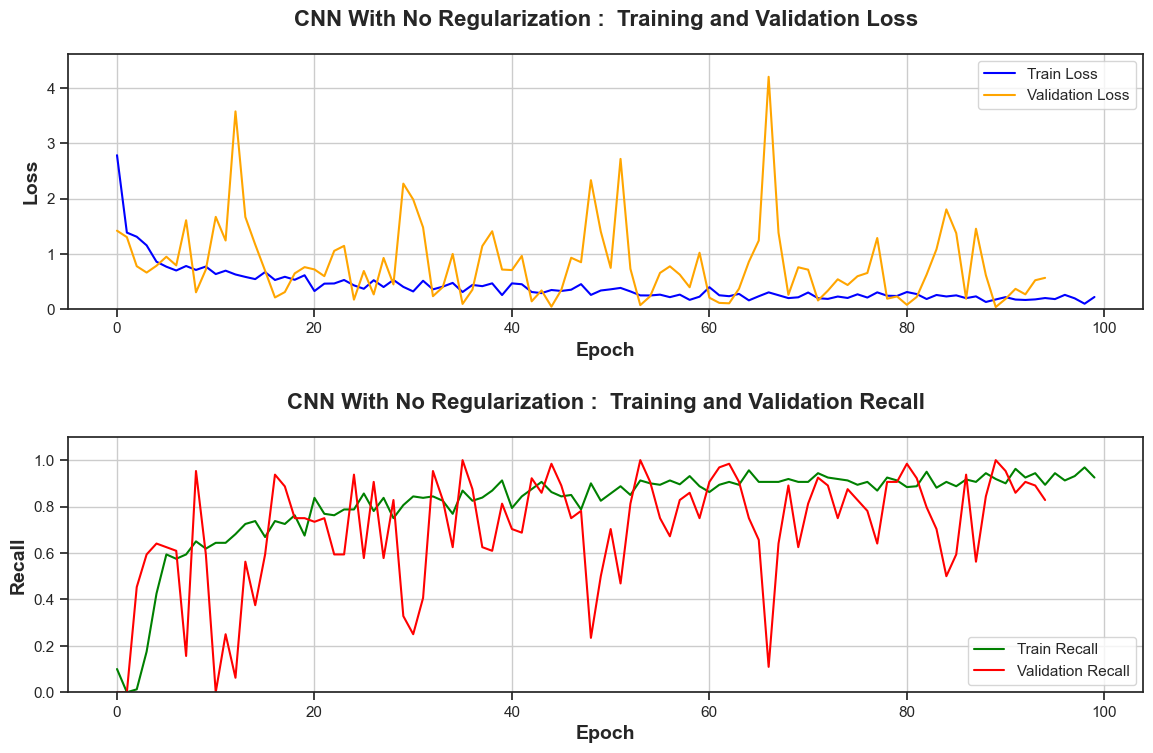

In [70]:
##################################
# Plotting the loss profile
# for CNN with no regularization
# on the training and validation sets
##################################
plot_training_history(model_nr_history, 'CNN With No Regularization : ')

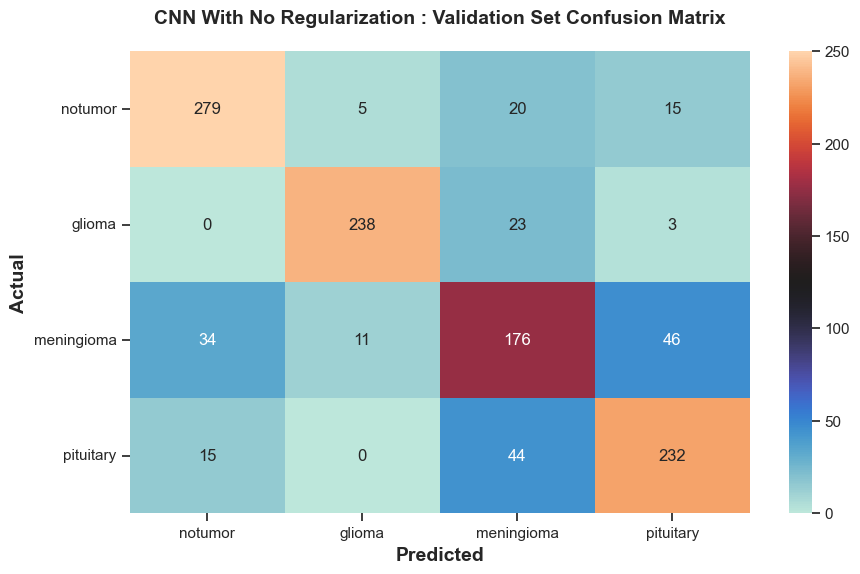

In [71]:
##################################
# Consolidating the predictions
# for CNN with no regularization
# on the validation set
##################################
model_nr_predictions = np.array(list(map(lambda x: np.argmax(x), model_nr_y_pred)))
model_nr_y_true = val_gen.classes

##################################
# Formulating the confusion matrix
# for CNN with no regularization
# on the validation set
##################################
CMatrix = pd.DataFrame(confusion_matrix(model_nr_y_true, model_nr_predictions), columns=classes, index =classes)

##################################
# Plotting the confusion matrix
# for CNN with no regularization
# on the validation set
##################################
plt.figure(figsize=(10, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'icefire')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0)
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0)
ax.set_title('CNN With No Regularization : Validation Set Confusion Matrix',fontsize = 14, weight = 'bold',pad=20);

##################################
# Resetting all states generated by Keras
##################################
keras.backend.clear_session()

In [72]:
##################################
# Calculating the model accuracy
# for CNN with no regularization
# for the entire validation set
##################################
model_nr_acc = accuracy_score(model_nr_y_true, model_nr_predictions)

##################################
# Calculating the model 
# Precision, Recall, F-score and Support
# for CNN with no regularization
# for the entire validation set
##################################
model_nr_results_all = precision_recall_fscore_support(model_nr_y_true, model_nr_predictions, average='macro',zero_division = 1)

##################################
# Calculating the model 
# Precision, Recall, F-score and Support
# for CNN with no regularization
# for each category of the validation set
##################################
model_nr_results_class = precision_recall_fscore_support(model_nr_y_true, model_nr_predictions, average=None, zero_division = 1)

##################################
# Consolidating all model evaluation metrics 
# for CNN with no regularization
##################################
metric_columns = ['Precision','Recall','F-Score','Support']
model_nr_all_df = pd.concat([pd.DataFrame(list(model_nr_results_class)).T,pd.DataFrame(list(model_nr_results_all)).T])
model_nr_all_df.columns = metric_columns
model_nr_all_df.index = ['No Tumor', 'Glioma', 'Meningioma', 'Pituitary', 'Total']
model_nr_all_df

Precision    Recall   F-Score  Support
No Tumor     0.850610  0.874608  0.862442    319.0
Glioma       0.937008  0.901515  0.918919    264.0
Meningioma   0.669202  0.659176  0.664151    267.0
Pituitary    0.783784  0.797251  0.790460    291.0
Total        0.810151  0.808138  0.808993      NaN

#### 1.6.3.2 CNN With Dropout Regularization <a class="anchor" id="1.6.3.2"></a>

In [73]:
##################################
# Formulating the network architecture
# for CNN with dropout regularization
##################################
set_seed()
batch_size = 32
input_shape = (299, 299, 1)
model_dr = Sequential()
model_dr.add(Conv2D(filters=32, kernel_size=(7, 7), activation='relu', padding='Same', input_shape=(299, 299, 1)))
model_dr.add(MaxPooling2D(pool_size=(2, 2)))
model_dr.add(Dropout(rate=0.50))
model_dr.add(Conv2D(filters=64, kernel_size=(7, 7), padding = 'Same', activation='relu'))
model_dr.add(MaxPooling2D(pool_size=(2, 2)))
model_dr.add(Dropout(rate=0.50))
model_dr.add(Flatten())
model_dr.add(Dense(units=128, activation='relu'))
model_dr.add(Dropout(rate=0.50))
model_dr.add(Dense(units=num_classes, activation='softmax'))

##################################
# Compiling the network layers
##################################
optimizer = Adam(learning_rate=0.001)
model_dr.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[Recall()])

In [74]:
##################################
# Displaying the model summary
# for CNN with dropout regularization
##################################
print(model_dr.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 299, 299, 32)        │           1,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 149, 149, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 149, 149, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 149, 149, 64)        │         100,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 74, 74, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 350464)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      44,859,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,962,052 (171.52 MB)

 Trainable params: 44,962,052 (171.52 MB)

 Non-trainable params: 0 (0.00 B)

None


In [75]:
##################################
# Displaying the model layers
# for CNN with dropout regularization
##################################
model_dr_layer_names = [layer.name for layer in model_dr.layers]
print("Layer Names:", model_dr_layer_names)

Layer Names: ['conv2d', 'max_pooling2d', 'dropout', 'conv2d_1', 'max_pooling2d_1', 'dropout_1', 'flatten', 'dense', 'dropout_2', 'dense_1']


In [76]:
##################################
# Displaying the number of weights
# for each model layer
# for CNN with dropout regularization
##################################
for layer in model_dr.layers:
    if hasattr(layer, 'weights'):
        print(f"Layer: {layer.name}, Number of Weights: {len(layer.get_weights())}")

Layer: conv2d, Number of Weights: 2
Layer: max_pooling2d, Number of Weights: 0
Layer: dropout, Number of Weights: 0
Layer: conv2d_1, Number of Weights: 2
Layer: max_pooling2d_1, Number of Weights: 0
Layer: dropout_1, Number of Weights: 0
Layer: flatten, Number of Weights: 0
Layer: dense, Number of Weights: 2
Layer: dropout_2, Number of Weights: 0
Layer: dense_1, Number of Weights: 2


In [77]:
##################################
# Displaying the number of weights
# for each model layer
# for CNN with dropout regularization
##################################
total_parameters = 0
for layer in model_dr.layers:
    layer_parameters = layer.count_params()
    total_parameters += layer_parameters
    print(f"Layer: {layer.name}, Parameters: {layer_parameters}")
print("\nTotal Parameters in the Model:", total_parameters)

Layer: conv2d, Parameters: 1600
Layer: max_pooling2d, Parameters: 0
Layer: dropout, Parameters: 0
Layer: conv2d_1, Parameters: 100416
Layer: max_pooling2d_1, Parameters: 0
Layer: dropout_1, Parameters: 0
Layer: flatten, Parameters: 0
Layer: dense, Parameters: 44859520
Layer: dropout_2, Parameters: 0
Layer: dense_1, Parameters: 516

Total Parameters in the Model: 44962052


In [78]:
##################################
# Fitting the model
# for CNN with dropout regularization
##################################
epochs = 100
set_seed()
model_dr_history = model_dr.fit(train_gen, 
                                steps_per_epoch=int(np.ceil(len(train_gen)/batch_size)),   
                                validation_steps=int(np.ceil(len(val_gen)/batch_size)), 
                                validation_data=val_gen, 
                                epochs=epochs,
                                verbose=0)

In [79]:
##################################
# Evaluating the model
# for CNN with dropout regularization
# on the independent validation set
##################################
model_dr_y_pred = model_dr.predict(val_gen)

36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 599ms/step


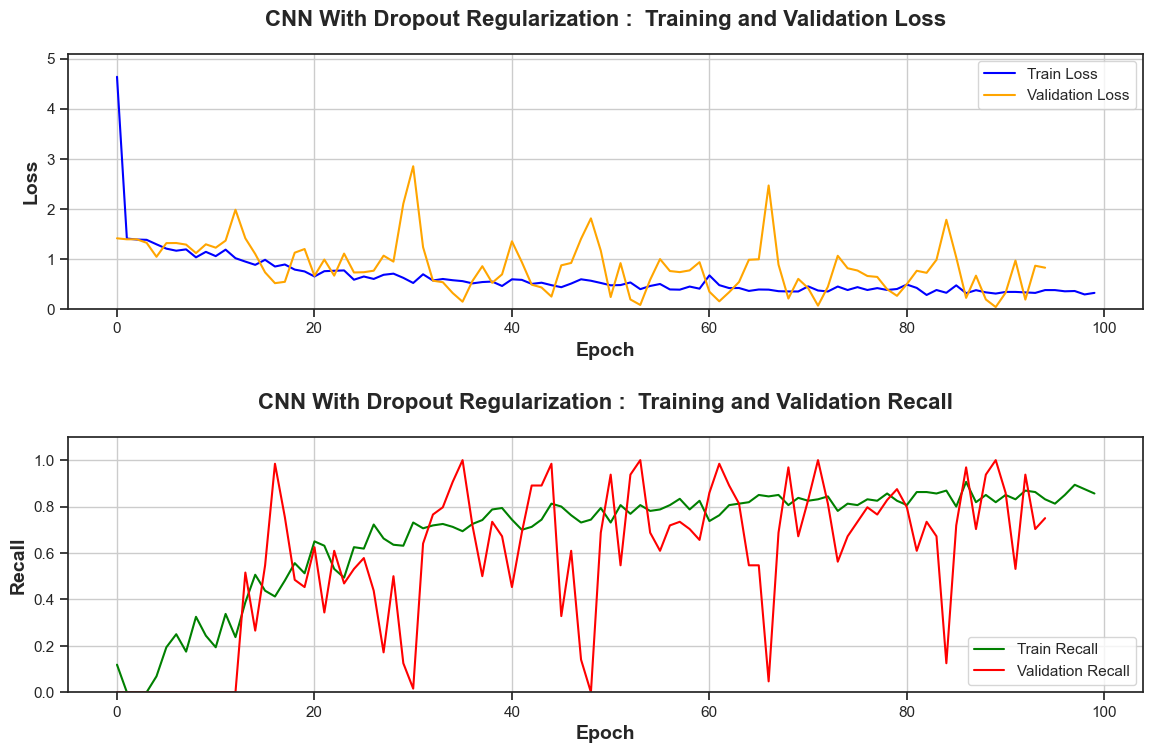

In [80]:
##################################
# Plotting the loss profile
# for CNN with dropout regularization
# on the training and validation sets
##################################
plot_training_history(model_dr_history, 'CNN With Dropout Regularization : ')

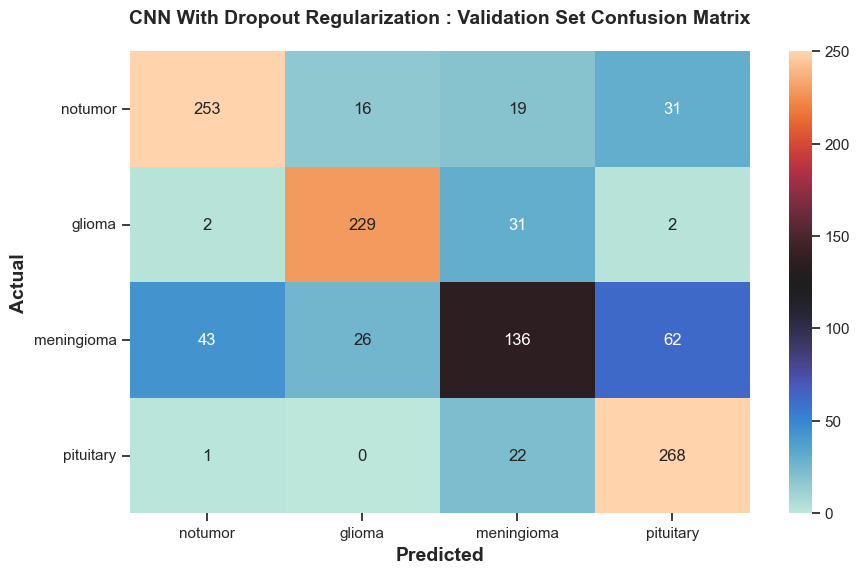

In [81]:
##################################
# Consolidating the predictions
# for CNN with dropout regularization
# on the validation set
##################################
model_dr_predictions = np.array(list(map(lambda x: np.argmax(x), model_dr_y_pred)))
model_dr_y_true=val_gen.classes

##################################
# Formulating the confusion matrix
# for CNN with dropout regularization
# on the validation set
##################################
CMatrix = pd.DataFrame(confusion_matrix(model_dr_y_true, model_dr_predictions), columns=classes, index =classes)

##################################
# Calculating the model 
# Precision, Recall, F-score and Support
# for CNN with dropout regularization
# for each category of the validation set
##################################
plt.figure(figsize=(10, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250, cmap = 'icefire')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0)
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0)
ax.set_title('CNN With Dropout Regularization : Validation Set Confusion Matrix',fontsize = 14, weight = 'bold', pad=20);

##################################
# Resetting all states generated by Keras
##################################
keras.backend.clear_session()

In [82]:
##################################
# Calculating the model accuracy
# for CNN with dropout regularization
# for the entire validation set
##################################
model_dr_acc = accuracy_score(model_dr_y_true, model_dr_predictions)

##################################
# Calculating the model 
# Precision, Recall, F-score and Support
# for CNN with dropout regularization
# for the entire validation set
##################################
model_dr_results_all = precision_recall_fscore_support(model_dr_y_true, model_dr_predictions, average='macro',zero_division = 1)

##################################
# Calculating the model 
# Precision, Recall, F-score and Support
# for CNN with dropout regularization
# for each category of the validation set
##################################
model_dr_results_class = precision_recall_fscore_support(model_dr_y_true, model_dr_predictions, average=None, zero_division = 1)

##################################
# Consolidating all model evaluation metrics 
# for CNN with dropout regularization
##################################
metric_columns = ['Precision','Recall', 'F-Score','Support']
model_dr_all_df = pd.concat([pd.DataFrame(list(model_dr_results_class)).T,pd.DataFrame(list(model_dr_results_all)).T])
model_dr_all_df.columns = metric_columns
model_dr_all_df.index = ['No Tumor', 'Glioma', 'Meningioma', 'Pituitary', 'Total']
model_dr_all_df

Precision    Recall   F-Score  Support
No Tumor     0.846154  0.793103  0.818770    319.0
Glioma       0.845018  0.867424  0.856075    264.0
Meningioma   0.653846  0.509363  0.572632    267.0
Pituitary    0.738292  0.920962  0.819572    291.0
Total        0.770828  0.772713  0.766762      NaN

#### 1.6.3.3 CNN With Batch Normalization Regularization <a class="anchor" id="1.6.3.3"></a>

#### 1.6.3.4 CNN With Dropout and Batch Normalization Regularization <a class="anchor" id="1.6.3.4"></a>

### 1.6.4 CNN With No Regularization Model Fitting | Hyperparameter Tuning | Validation <a class="anchor" id="1.6.4"></a>

### 1.6.5 CNN With Dropout Regularization Model Fitting | Hyperparameter Tuning | Validation <a class="anchor" id="1.6.5"></a>

### 1.6.6 CNN With Batch Normalization Regularization Model Fitting | Hyperparameter Tuning | Validation <a class="anchor" id="1.6.6"></a>

### 1.6.7 CNN With Dropout and Batch Normalization Regularization Model Fitting | Hyperparameter Tuning | Validation <a class="anchor" id="1.6.7"></a>

### 1.6.8 Model Selection <a class="anchor" id="1.6.8"></a>

### 1.6.9 Model Testing <a class="anchor" id="1.6.9"></a>

### 1.6.10 Model Inference <a class="anchor" id="1.6.10"></a>

## 1.7 Predictive Model Development <a class="anchor" id="1.7"></a>

### 1.7.1 Model Application Programming Interface Code Development <a class="anchor" id="1.7.1"></a>

### 1.7.2 User Interface Application Code Development <a class="anchor" id="1.7.2"></a>

### 1.7.3 Web Application <a class="anchor" id="1.7.3"></a>

# 2. Summary <a class="anchor" id="Summary"></a>

# 3. References <a class="anchor" id="References"></a>
* **[Book]** [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python) by Francois Chollet
* **[Book]** [Deep Learning: A Visual Approach](https://nostarch.com/deep-learning-visual-approach) by Andrew Glassner
* **[Book]** [Learning Deep Learning](https://ldlbook.com/) by Magnus Ekman
* **[Book]** [Practical Deep Learning](https://nostarch.com/practical-deep-learning-python) by Ronald Kneusel
* **[Book]** [Deep Learning with Tensorflow and Keras](https://www.packtpub.com/product/deep-learning-with-tensorflow-and-keras-third-edition/9781803232911) by Amita Kapoor, Antonio Gulli and Sujit Pal
* **[Book]** [Deep Learning](https://mitpress.mit.edu/9780262537551/deep-learning/) by John Kelleher
* **[Book]** [Generative Deep Learning](https://www.oreilly.com/library/view/generative-deep-learning/9781098134174/) by David Foster
* **[Book]** [Deep Learning Illustrated](https://www.deeplearningillustrated.com/) by John Krohn, Grant Beyleveld and Aglae Bassens
* **[Book]** [Neural Networks and Deep Learning](https://link.springer.com/book/10.1007/978-3-319-94463-0) by Charu Aggarwal
* **[Book]** [Grokking Deep Learning](https://www.manning.com/books/grokking-deep-learning) by Andrew Trask
* **[Book]** [Deep Learning with Pytorch](https://www.manning.com/books/deep-learning-with-pytorch) by Eli Stevens, Luca Antiga and Thomas Viehmann
* **[Book]** [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio and Aaron Courville
* **[Book]** [Deep Learning from Scratch](https://www.oreilly.com/library/view/deep-learning-from/9781492041405/) by Seth Weidman
* **[Book]** [Fundamentals of Deep Learning](https://www.oreilly.com/library/view/fundamentals-of-deep/9781492082170/) by Nithin Buduma, Nikhil Buduma and Joe Papa
* **[Book]** [Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) by Aurelien Geron
* **[Book]** [Deep Learning for Computer Vision](https://machinelearningmastery.com/deep-learning-for-computer-vision/) by Jason Brownlee
* **[Python Library API]** [numpy](https://numpy.org/doc/) by NumPy Team
* **[Python Library API]** [pandas](https://pandas.pydata.org/docs/) by Pandas Team
* **[Python Library API]** [seaborn](https://seaborn.pydata.org/) by Seaborn Team
* **[Python Library API]** [matplotlib.pyplot](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html) by MatPlotLib Team
* **[Python Library API]** [matplotlib.image](https://matplotlib.org/stable/api/image_api.html) by MatPlotLib Team
* **[Python Library API]** [matplotlib.offsetbox](https://matplotlib.org/stable/api/offsetbox_api.html) by MatPlotLib Team
* **[Python Library API]** [tensorflow](https://pypi.org/project/tensorflow/) by TensorFlow Team
* **[Python Library API]** [keras](https://pypi.org/project/keras/) by Keras Team
* **[Python Library API]** [pil](https://pypi.org/project/Pillow/) by Pillow Team
* **[Python Library API]** [glob](https://docs.python.org/3/library/glob.html) by glob Team
* **[Python Library API]** [cv2](https://pypi.org/project/opencv-python/) by OpenCV Team
* **[Python Library API]** [os](https://docs.python.org/3/library/os.html) by os Team
* **[Python Library API]** [random](https://docs.python.org/3/library/random.html) by random Team
* **[Python Library API]** [keras.models](https://www.tensorflow.org/api_docs/python/tf/keras/models) by TensorFlow Team
* **[Python Library API]** [keras.layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers) by TensorFlow Team
* **[Python Library API]** [keras.wrappers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Wrapper) by TensorFlow Team
* **[Python Library API]** [keras.utils](https://www.tensorflow.org/api_docs/python/tf/keras/utils) by TensorFlow Team
* **[Python Library API]** [keras.optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) by TensorFlow Team
* **[Python Library API]** [keras.preprocessing.image](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image) by TensorFlow Team
* **[Python Library API]** [keras.callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) by TensorFlow Team
* **[Python Library API]** [keras.metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) by TensorFlow Team
* **[Python Library API]** [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) by Scikit-Learn Team
* **[Article]** [Convolutional Neural Networks, Explained](https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939) by Mayank Mishra (Towards Data Science)
* **[Article]** [A Comprehensive Guide to Convolutional Neural Networks — the ELI5 way](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) by Sumit Saha (Towards Data Science)
* **[Article]** [Understanding Convolutional Neural Networks: A Beginner’s Journey into the Architecture](https://medium.com/codex/understanding-convolutional-neural-networks-a-beginners-journey-into-the-architecture-aab30dface10) by Afaque Umer (Medium)
* **[Article]** [Introduction to Convolutional Neural Networks (CNN)](https://www.analyticsvidhya.com/blog/2021/05/convolutional-neural-networks-cnn/) by Manav Mandal (Analytics Vidhya)
* **[Article]** [What Are Convolutional Neural Networks?](https://www.ibm.com/topics/convolutional-neural-networks) by IBM Team (IBM)
* **[Article]** [What is CNN? A 5 Year Old guide to Convolutional Neural Network](https://medium.com/analytics-vidhya/what-is-cnn-a-5-year-old-guide-to-convolutional-neural-network-c9d0338c3bf7) by William Ong (Medium)
* **[Article]** [Convolutional Neural Network](https://deepai.org/machine-learning-glossary-and-terms/convolutional-neural-network) by Thomas Wood (DeepAI.Org)
* **[Article]** [How Do Convolutional Layers Work in Deep Learning Neural Networks?](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/) by Jason Brownlee (Machine Learning Mastery)
* **[Article]** [Convolutional Neural Networks Explained: Using PyTorch to Understand CNNs](https://builtin.com/data-science/convolutional-neural-networks-explained) by Vihar Kurama (BuiltIn)
* **[Article]** [Convolutional Neural Networks Cheatsheet](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks) by Afshine Amidi and Shervine Amidi (Stanford University)
* **[Article]** [An Intuitive Explanation of Convolutional Neural Networks](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/) by Ujjwal Karn (The Data Science Blog)
* **[Article]** [Convolutional Neural Network](https://www.nvidia.com/en-us/glossary/data-science/convolutional-neural-network/) by NVIDIA Team (NVIDIA)
* **[Article]** [Convolutional Neural Networks (CNN) Overview](https://encord.com/blog/convolutional-neural-networks-explained/) by Nikolaj Buhl (Encord)
* **[Article]** [Understanding Convolutional Neural Network (CNN): A Complete Guide](https://learnopencv.com/understanding-convolutional-neural-networks-cnn/) by LearnOpenCV Team (LearnOpenCV)
* **[Article]** [Convolutional Neural Networks (CNNs) and Layer Types](https://pyimagesearch.com/2021/05/14/convolutional-neural-networks-cnns-and-layer-types/) by Adrian Rosebrock (PyImageSearch)
* **[Article]** [How Convolutional Neural Networks See The World](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html) by Francois Chollet (The Keras Blog)
* **[Article]** [What Is a Convolutional Neural Network?](https://www.mathworks.com/discovery/convolutional-neural-network-matlab.html#:~:text=A%20convolutional%20neural%20network%20(CNN,%2Dseries%2C%20and%20signal%20data.) by MathWorks Team (MathWorks)
* **[Article]** [Grad-CAM Class Activation Visualization](https://keras.io/examples/vision/grad_cam/) by Francois Chollet (Keras.IO)
* **[Article]** [Grad-CAM: Visualize Class Activation Maps with Keras, TensorFlow, and Deep Learning](https://pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/) by Adrian Rosebrock (PyImageSearch)
* **[Kaggle Project]** [glioma 19 Radiography Data - EDA and CNN Model](https://www.kaggle.com/code/jnegrini/glioma-19-radiography-data-eda-and-cnn-model) by Juliana Negrini De Araujo (Kaggle)
* **[Kaggle Project]** [Pneumonia Detection using CNN (92.6% Accuracy)](https://www.kaggle.com/code/madz2000/pneumonia-detection-using-cnn-92-6-accuracy) by Madhav Mathur (Kaggle)
* **[Kaggle Project]** [glioma Detection from CXR Using Explainable CNN](https://www.kaggle.com/code/sid321axn/glioma-detection-from-cxr-using-explainable-cnn) by Manu Siddhartha (Kaggle)
* **[Kaggle Project]** [Class Activation Mapping for glioma-19 CNN](https://www.kaggle.com/code/amyjang/class-activation-mapping-for-glioma-19-cnn) by Amy Zhang (Kaggle)
* **[Kaggle Project]** [CNN mri glioma Classification](https://www.kaggle.com/code/gabrielmino/cnn-mri-glioma-classification) by Gabriel Mino (Kaggle)
* **[Kaggle Project]** [Detecting-glioma-19-Images | CNN](https://www.kaggle.com/code/felipeoliveiraml/detecting-glioma-19-images-cnn) by Felipe Oliveira (Kaggle)
* **[Kaggle Project]** [Detection of glioma Positive Cases using DL](https://www.kaggle.com/code/sana306/detection-of-glioma-positive-cases-using-dl) by Sana Shaikh (Kaggle)
* **[Kaggle Project]** [Deep Learning and Transfer Learning on glioma-19](https://www.kaggle.com/code/digvijayyadav/deep-learning-and-transfer-learning-on-glioma-19) by Digvijay Yadav (Kaggle)
* **[Kaggle Project]** [X-ray Detecting Using CNN](https://www.kaggle.com/code/shivan118/x-ray-detecting-using-cnn) by Shivan Kumar (Kaggle)
* **[Kaggle Project]** [Classification of glioma-19 using CNN](https://www.kaggle.com/code/islamselim/classification-of-glioma-19-using-cnn) by Islam Selim (Kaggle)
* **[Kaggle Project]** [glioma-19 - Revisiting Pneumonia Detection](https://www.kaggle.com/code/pcbreviglieri/glioma-19-revisiting-pneumonia-detection) by Paulo Breviglieri (Kaggle)
* **[Kaggle Project]** [Multi-Class X-ray glioma19 Classification-94% Accurary](https://www.kaggle.com/code/derrelldsouza/multi-class-x-ray-glioma19-classification-94-acc) by Quadeer Shaikh (Kaggle)
* **[Kaggle Project]** [Grad-CAM: What Do CNNs See?](https://www.kaggle.com/code/quadeer15sh/grad-cam-what-do-cnns-see) by Derrel Souza (Kaggle)
* **[GitHub Project]** [Grad-CAM](https://github.com/ismailuddin/gradcam-tensorflow-2/blob/master/notebooks/GradCam.ipynb) by Ismail Uddin (GitHub)
* **[Publication]** [Gradient-Based Learning Applied to Document Recognition](https://ieeexplore.ieee.org/document/726791) by Yann LeCun, Leon Bottou, Yoshua Bengio and Patrick Haffner (Proceedings of the IEEE)
* **[Publication]** [Learning Deep Features for Discriminative Localization](https://arxiv.org/abs/1512.04150) by Bolei Zhou, Aditya Khosla, Agata Lapedriza, Aude Oliva and Antonio Torralba (Computer Vision and Pattern Recognition)
* **[Publication]** [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391) by Ramprasaath Selvaraju, Michael Cogswell, Abhishek Das, Ramakrishna Vedantam, Devi Parikh and Dhruv Batra (Computer Vision and Pattern Recognition)
* **[Course]** [IBM Data Analyst Professional Certificate](https://www.coursera.org/professional-certificates/ibm-data-analyst) by IBM Team (Coursera)
* **[Course]** [IBM Data Science Professional Certificate](https://www.coursera.org/professional-certificates/ibm-data-science) by IBM Team (Coursera)
* **[Course]** [IBM Machine Learning Professional Certificate](https://www.coursera.org/professional-certificates/ibm-machine-learning) by IBM Team (Coursera)

In [83]:
from IPython.display import display, HTML
display(HTML("<style>.rendered_html { font-size: 15px; font-family: 'Trebuchet MS'; }</style>"))